## Pytorch based U-Net for Fault Prediction

In [3]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
     ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 GB 63.0 MB/s eta 0:00:40
     ---------------------------------------- 0.0/2.5 GB 59.1 MB/s eta 0:00:43
     ---------------------------------------- 0.0/2.5 GB 73.6 MB/s eta 0:00:35
     ---------------------------------------- 0.0/2.5 GB 110.0 MB/s eta 0:00:23
     ---------------------------------------- 0.0/2.5 GB 108.8 MB/s eta 0:00:23
     ---------------------------------------- 0.0/2.5 GB 131.2 MB/s eta 0:00:19
     ---------------------------------------- 0.0/2.5 GB 110.0 MB/s eta 0:00:23
      --------------------------------------- 0.0/2.5 GB 108.8 MB/s eta 0:00:23
      --------------------------------------- 0.0/2.5 GB 110.0 MB/s eta 0:00:23
      --------------------------------------- 0.0/2.5 GB 110.0 MB/s eta 0:00:23
      --------------------------------------- 0.0/2.5 GB 108.8 MB/s eta 0

In [2]:
pip install segyio

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [200]:
!pip install xarray

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 20.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [201]:
import segyio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from utils import *
torch.manual_seed(0)

### Contracting Path
The contracting path is the encoder section of the U-Net which involves several downsampling steps.
It consists of the repeated application of two 3x3 convolutions (unpadded), each followed by a ReLU and 2x2 max pooling operation with stride of 2 for downsampling. At each downsampling step we double the number of feature channels.
Note: in the original U-Net framework, the resulting output has smaller size than the input. I am using a padding of (1,1) to make sure we get the same shape as input in Expanding block.

In [202]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        
        # Wou want to double the number of channels in the first convolution
        # and keep the same number of channels in the second.
        
        self.conv1 = nn.Conv2d(input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
       

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

In [203]:
# unit test
def test_contracting_block(test_samples = 1, test_channels=1, test_size=254):
    test_block = ContractingBlock(test_channels)
    test_in = torch.randn(test_samples, test_channels, test_size, test_size)
    test_out_conv1 = test_block.conv1(test_in)
    
    # Make sure that the first convolution has the right shape
    print(test_out_conv1.shape)
#     print(test_block.shape)

In [204]:
test_contracting_block(128)
# 1, 512, 60, 60

torch.Size([128, 2, 254, 254])


### Expanding Path
This is the decodign section of U-Net which has several upsampling steps. Original UNET needs this crop function in order to crop the image from contracting path and concatenate it to the current image on the expanding path - this is to form a skip connection. For our purpose, we want the input and output to be of same shape so we won't be applying these function in this experiment. However, I am leaving it here, if in case any of these is useful in the future. 

Every step in expanding path consists of an upsampling of the feature map followed by a 2x2 convolution("up-convolution") that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from contracting path and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution.
(Later models basded on U-Net often use padding in the convolutions to prevent the size of the image from changing outside of the upsampling /downsampling steps)

In [205]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    # There are many ways to implement this crop function, but it's what allows
    # the skip connection to function as intended with two differently sized images!
    #### START CODE HERE ####
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - new_shape[2] // 2
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - new_shape[3] // 2
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    #### END CODE HERE ####
    return cropped_image

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)      
        self.conv1 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv3 = nn.Conv2d(input_channels//2, input_channels//2, kernel_size=3, padding=(1,1))
        
        self.activation = nn.ReLU() # "each followed by a ReLU"
 
    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
                    
        Note: In the original Unet implementation, the output shape is smaller than the input, which 
        requires a skip connection layer size to be matched with current layer. 
        In this application, since our input and output are to be same size, we will note crop the 
        skip connection layer. However, there is a placehold commented, if needed in future. 
        
        '''
        x = self.upsample(x)
        x = self.conv1(x)    
        skip_con_x = crop(skip_con_x, x.shape)    
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x

In [206]:
#UNIT TEST
def test_expanding_block(test_samples=1, test_channels=64*16, test_size=32):
    test_block = ExpandingBlock(test_channels)
    skip_con_x = torch.randn(test_samples, test_channels // 2, test_size * 2 + 6, test_size * 2 + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    x = test_block.upsample(x)
    # Make sure that the first convolution produces the right shape
    print(x.shape)

test_expanding_block()

torch.Size([1, 1024, 64, 64])


### Final Layer
This layer takes in a tensor with arbitrarily many tensors and produces a tensor with the same number of pixels but with the correct number of the output channels. 
At the final layer, a 1x1 convolution is used to map each 64-component feature vectore to the desired number of classes. In total the network has 23 convolutional layers

In [207]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a UNet - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

## U-Net

In [208]:
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        
    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        # Keep in mind that the expand function takes two inputs, 
        # both with the same number of channels.                 
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)      
        x2 = self.contract2(x1)     
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)
        xn_upsampled = F.interpolate(xn, size=x.size()[2:], mode='bilinear', align_corners=False)
        return xn_upsampled

In [209]:
# unit test
test_unet = UNet(1,1)
# print(test_unet(torch.randn(1, 1, 256, 256)).shape)
print(test_unet(torch.randn(1, 1, 512, 512)).shape)

torch.Size([1, 1, 512, 512])


## Prepare for modelling

In [226]:
# First load datasets
filename_pp = "dark-side-train-data-part1/2023-10-05_0552b11a/seismicCubes_RFC_fullstack_2023.76178225.npy"
filename_fault = "dark-side-train-data-part1/2023-10-05_0552b11a/fault_segments_2023.76178225.npy"

In [229]:
# Note: the the xline header info location is at segyio.su.cdpx [181]
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)
def load_numpy_file(filepath: str) -> np.ndarray:
    return np.load(filepath)
seismic = load_numpy_file(filename_pp)
seismic_rescaled = rescale_volume(seismic, low=2, high=98)
fault = load_numpy_file(filename_fault)
f"Number of inlines: {seismic.shape[0]}, crosslines: {seismic.shape[1]}, samples: {seismic.shape[2]}"

'Number of inlines: 300, crosslines: 300, samples: 1259'

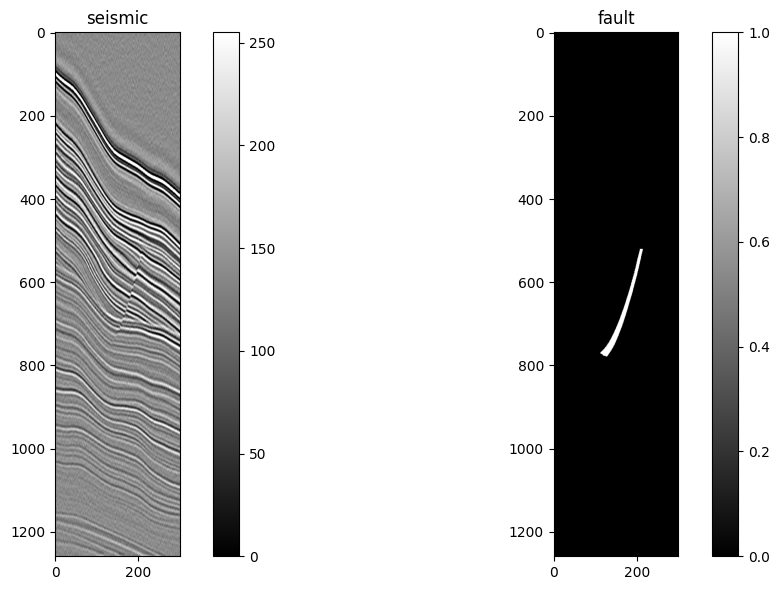

In [245]:
seismic_rescaled = rescale_volume(seismic, low=2, high=98)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax[0].imshow(seismic_rescaled[220, ...].T, cmap="gray")
ax[0].set_title("seismic")
fig.colorbar(im1, ax=ax[0], orientation="vertical")

# Plot the second image with a colorbar
im2 = ax[1].imshow(fault[220, ...].T, cmap="gray")
ax[1].set_title("fault")
fig.colorbar(im2, ax=ax[1], orientation="vertical")

plt.tight_layout()
plt.show()

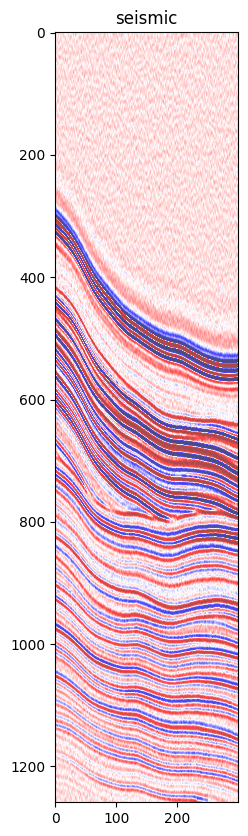

In [246]:
# plot inline
ILINE=10
plt.figure(figsize=(10, 10))
title = ['seismic', 'Faults overalay']
cmaps = ["seismic", None]

for i, cube in enumerate([seismic_rescaled]):
    plt.title(title[i])
    plt.imshow(cube[ILINE,:, :].T, cmap=cmaps[i])
    plt.imshow(fault[ILINE,:, :].T, cmap='Greys',  vmin=0, vmax=1, alpha=0.3)
    plt.axis()
plt.show()

### Cropping Input to the shape

The function below is to crop or pad the input data to make into the shape that is multiple of 32x32 or any combination.
The real shape of the synthetic data (589x751) was causing problem. This is a quick workaround to get some experiment going on.
Ideally, we want to use the actual shape of the data, until I find the solution.

In [232]:
def crop_input(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    
    h, w = image.shape[0], image.shape[1]   # values inside the brackets depends on the input shapes
    new_h, new_w = new_shape[0], new_shape[1]
    
    start_h = int((h - new_h + 1)/2)
    start_w = int((w - new_w + 1)/2)
    
    cropped_image = image[start_h:start_h + new_h, start_w:start_w + new_w] 
    
    return cropped_image

# Function to pad 
import torch.nn.functional as F

def pad_to(image, new_shape):
    '''
    Function for padding an image tensor. 
    If somehow the expanding layer output and the skip connection doesn't match,
    these might be helpful.
    '''
    h, w = image.shape[0], image.shape[1]
    new_h, new_w = new_shape[0], new_shape[1]
    
    inc_h, inc_w = new_h -h, new_w - w
    left, right = 0, inc_w
    top, bottom = 0, inc_h
    pads = left, right, top, bottom 
    
    # zero-padding by default.
    # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
    padded_image = F.pad(image, pads, "constant", 0)

    return padded_image

In [233]:
# Some manipulation to get the data into right shape to be input for the UNET model.

'''
Earlier, I had problem feeding the data into the network in the current shape which is (101, 512, 512)
The Pytorch implementation requires: (m, n, h, w) shape where,
m = no. of samples (in this case, no. of inlines)
n = number of channel ( 1 for greyscale or single channel)
h, w = 512
By concatenating each inlines into the list, I am trying to pretend each item on the list is a 2D image.
After that, we unsqueeze in the position (0) to add a 1 dimension, i.e (1 x 512 x 512)
Finally, we will stack all the item in the list to get a desired shape of (101, 1, 512, 512)
'''

'\nEarlier, I had problem feeding the data into the network in the current shape which is (101, 512, 512)\nThe Pytorch implementation requires: (m, n, h, w) shape where,\nm = no. of samples (in this case, no. of inlines)\nn = number of channel ( 1 for greyscale or single channel)\nh, w = 512\nBy concatenating each inlines into the list, I am trying to pretend each item on the list is a 2D image.\nAfter that, we unsqueeze in the position (0) to add a 1 dimension, i.e (1 x 512 x 512)\nFinally, we will stack all the item in the list to get a desired shape of (101, 1, 512, 512)\n'

In [234]:
new_shape = (512, 512)
image_list = []
fault_list = []
for i in range(len(seismic)):
    images = torch.from_numpy(seismic[i])
    image_list.append(crop_input(images, new_shape ).unsqueeze(0))
    
    faults = torch.from_numpy(fault[i])
    fault_list.append(crop_input(faults, new_shape).unsqueeze(0))

In [235]:
image_list[0].shape

torch.Size([1, 105, 512])

In [236]:
# Loading data into Pytorch Dataset Utitlity
volumes = torch.stack(image_list)
labels = torch.stack(fault_list)
dataset = torch.utils.data.TensorDataset(volumes, labels)

In [237]:
volumes.shape, labels.shape

(torch.Size([300, 1, 105, 512]), torch.Size([300, 1, 105, 512]))

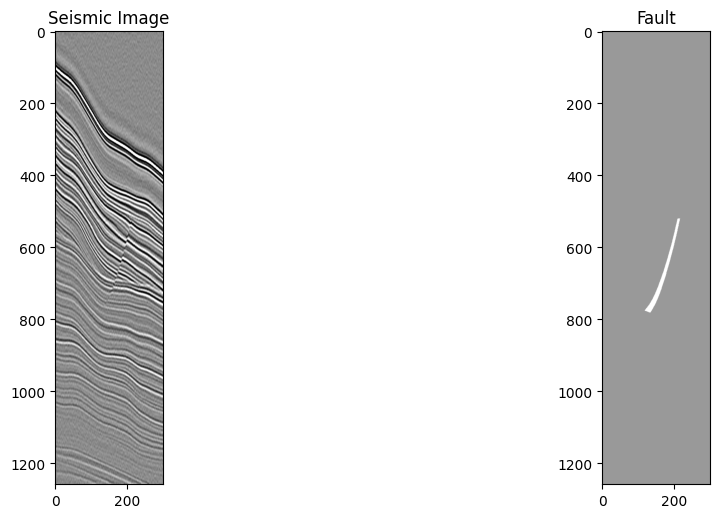

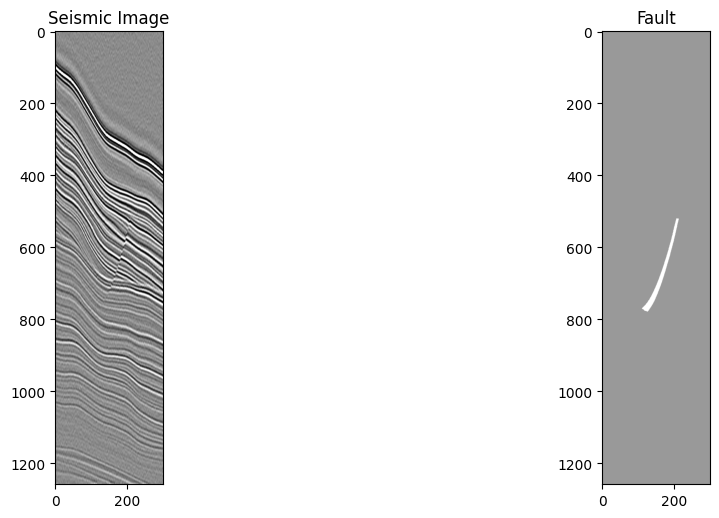

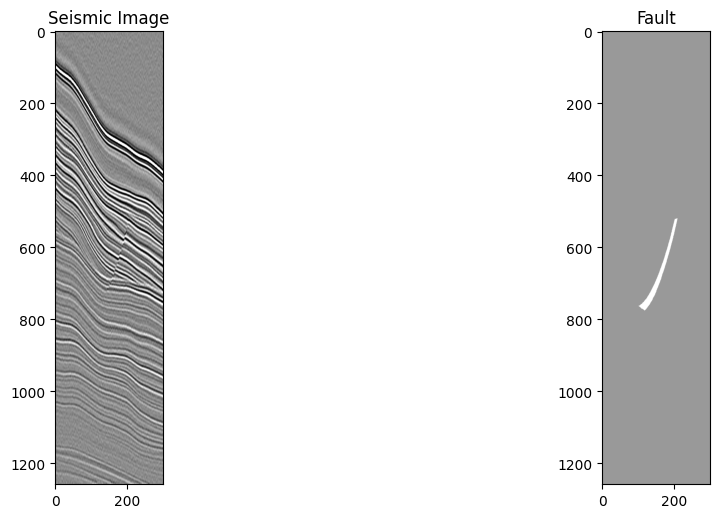

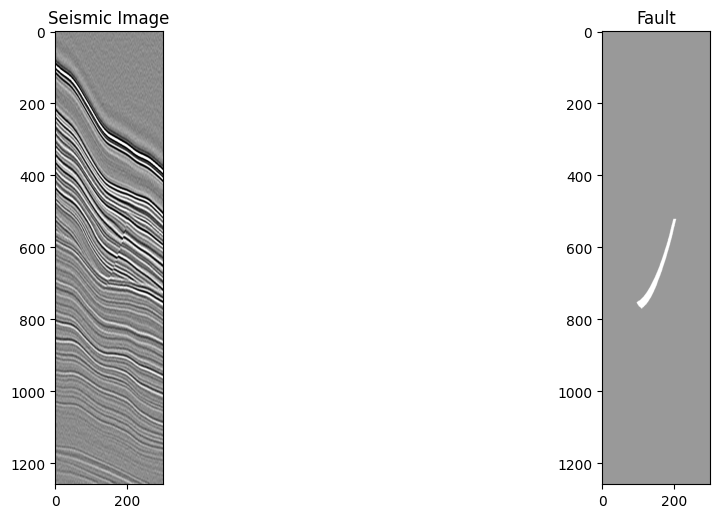

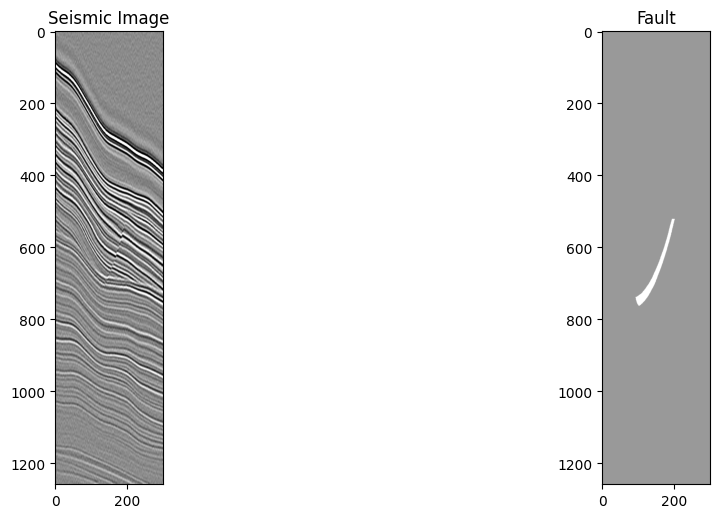

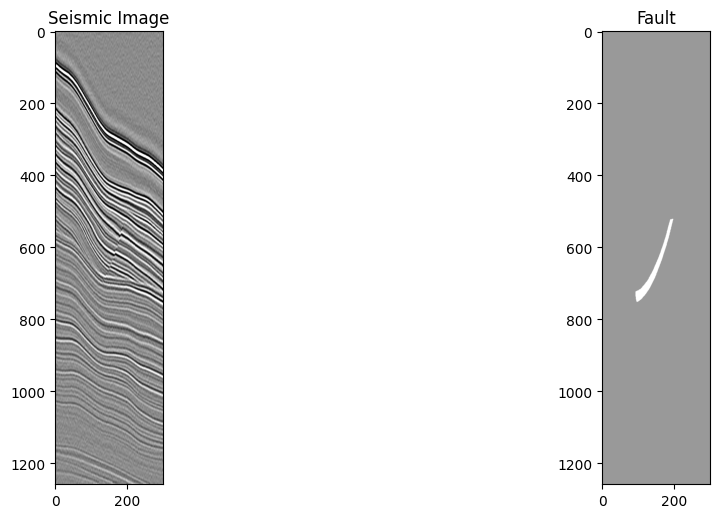

In [ ]:
for i in range(219, 225):
    # One last sanity check
    fig = plt.figure(figsize=(20,20))
        
    ax = fig.add_subplot(331)    
    plt.imshow(seismic_rescaled[i, ...].T, cmap="gray")
    ax.set_title("Seismic Image")
        
    ax = fig.add_subplot(332)
    # ax.imshow(volumes[0].T, cmap = 'gray')
    ax.imshow(fault[i, ...].T, cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Fault")
    plt.show()

In [257]:
# Special function to display images side by side after training

def show_tensor_images(image, fault, pred, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    # image_shifted = (image_tensor + 1) / 2
    #image_shifted = image_tensor
    
    image_unflat = image.detach().cpu()
    fault_unflat = fault.detach().cpu()
    pred_unflat = pred.detach().cpu()
    
    
    fig = plt.figure(figsize=(12,15))
    
    ax = fig.add_subplot(331)    
    ax.imshow(image_unflat.squeeze(), cmap = 'gray')
    ax.set_title("Seismic Image")
    
    ax = fig.add_subplot(332)
    ax.imshow(fault_unflat.squeeze(), cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Fault")
    
    ax = fig.add_subplot(333)
    ax.imshow(pred_unflat.squeeze(), cmap = 'gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Predicted Fault")
    
    plt.show()

### Training

  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   input_dim: the number of channels of the input image
  *   label_dim: the number of channels of the output image
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   initial_shape: the size of the input image (in pixels)
  *   target_shape: the size of the output image (in pixels)
  *   device: the device type

In [258]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [262]:
# Hyperparameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 30    
input_dim = 1
label_dim = 1
display_step = 100
batch_size = 1
lr = 0.0002
initial_shape = 512
target_shape = 512
device = 'cuda'

In [268]:
def train():
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)
    unet = UNet(input_dim, label_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0
    
    train_losses = []

    for epoch in range(n_epochs):
                
        for real, labels in tqdm(dataloader):
            
            cur_batch_size = len(real)
            # Flatten the image
            real = real.float()
            real = real.to(device)
            labels = labels.float()
            labels = labels.to(device)            
                      

            ### Update U-Net ###
            unet_opt.zero_grad()
            pred = unet(real)
            unet_loss = criterion(pred, labels)
            unet_loss.backward()
            unet_opt.step()
            

            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                show_tensor_images(real.T, labels.T, torch.sigmoid(pred).T, size=(input_dim, target_shape, target_shape))
            cur_step += 1
        
        train_losses.append(unet_loss)
               
        
    return unet, pred, train_losses

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 0: Step 0: U-Net loss: 0.9028405547142029


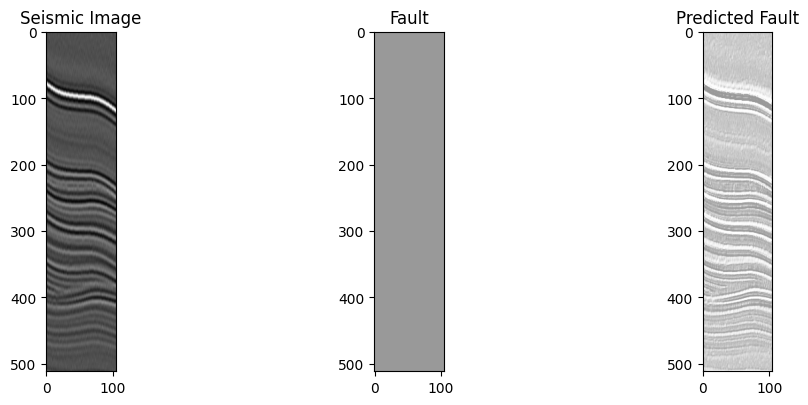

 33%|███▎      | 100/300 [03:29<06:59,  2.10s/it]

Epoch 0: Step 100: U-Net loss: 0.21005263924598694


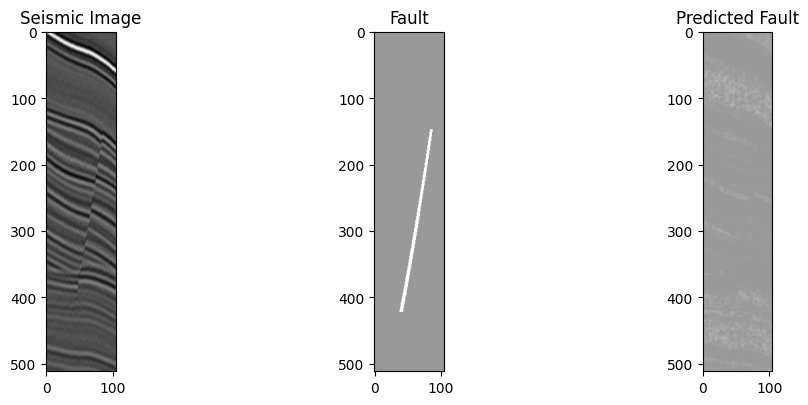

 67%|██████▋   | 200/300 [07:00<03:30,  2.10s/it]

Epoch 0: Step 200: U-Net loss: 0.015344897285103798


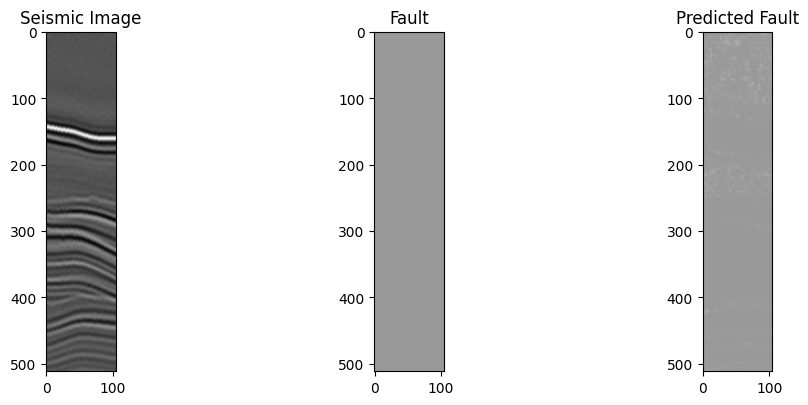

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Step 300: U-Net loss: 0.01300529669970274


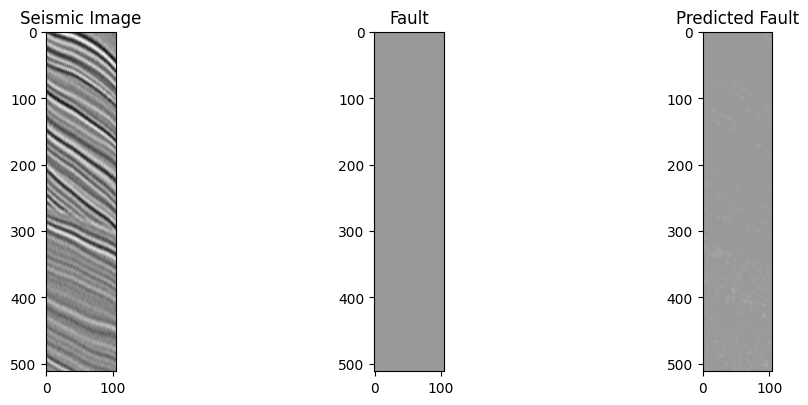

 33%|███▎      | 100/300 [03:30<07:00,  2.10s/it]

Epoch 1: Step 400: U-Net loss: 0.03194018080830574


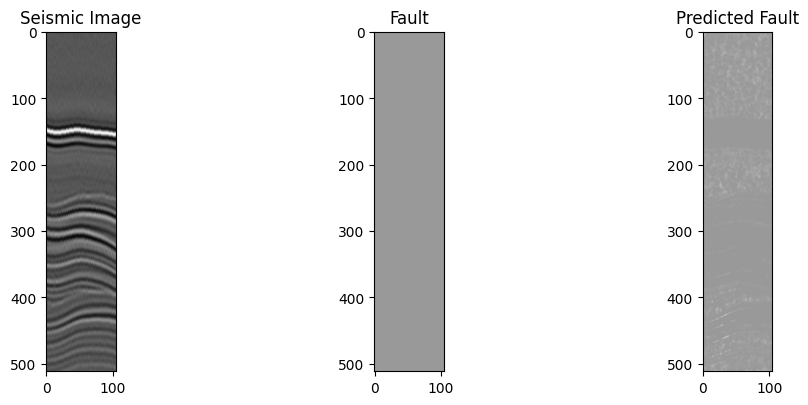

 67%|██████▋   | 200/300 [07:01<03:30,  2.11s/it]

Epoch 1: Step 500: U-Net loss: 0.014791932888329029


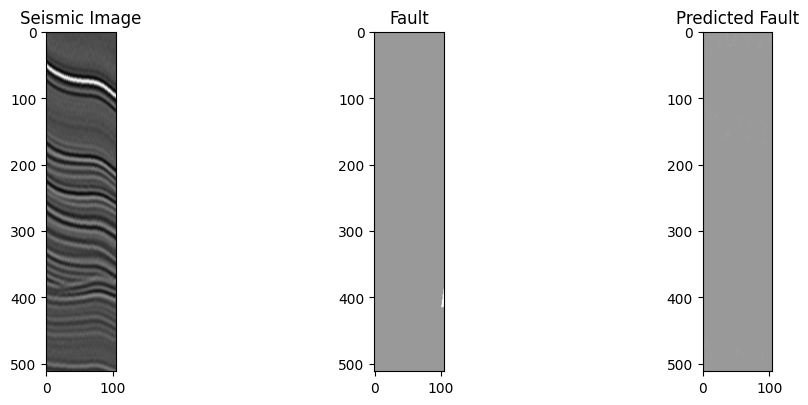

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 2: Step 600: U-Net loss: 0.014362386427819729


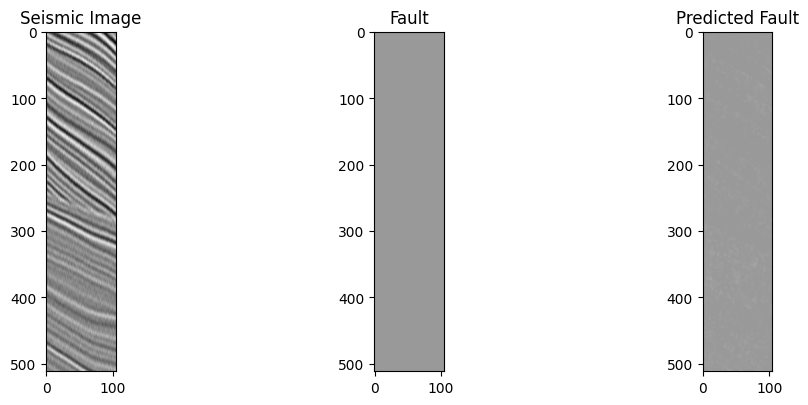

 33%|███▎      | 100/300 [03:30<06:59,  2.10s/it]

Epoch 2: Step 700: U-Net loss: 0.160824716091156


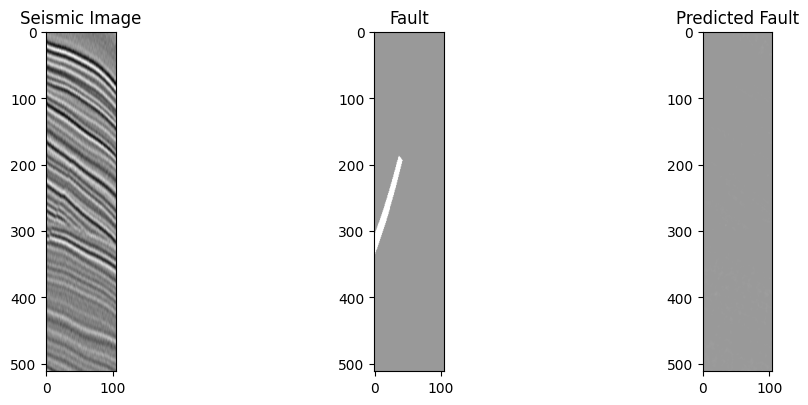

 67%|██████▋   | 200/300 [07:03<03:32,  2.12s/it]

Epoch 2: Step 800: U-Net loss: 0.15429936349391937


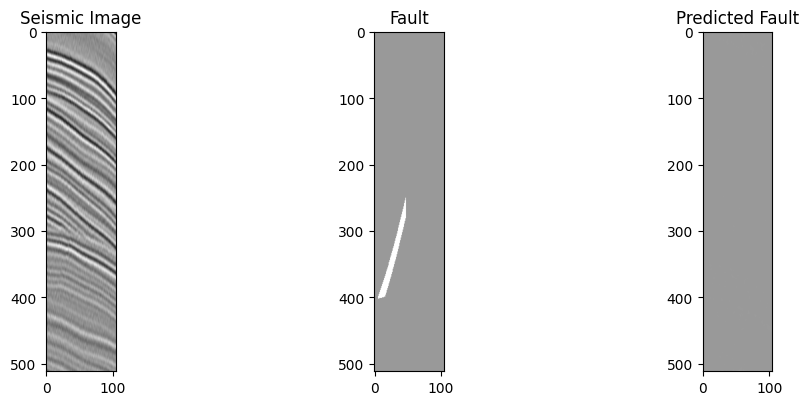

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 3: Step 900: U-Net loss: 0.09727182239294052


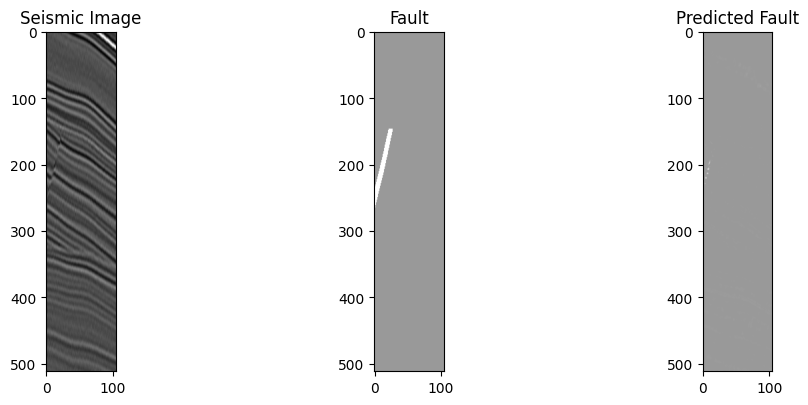

 33%|███▎      | 100/300 [03:32<07:02,  2.11s/it]

Epoch 3: Step 1000: U-Net loss: 0.11966388672590256


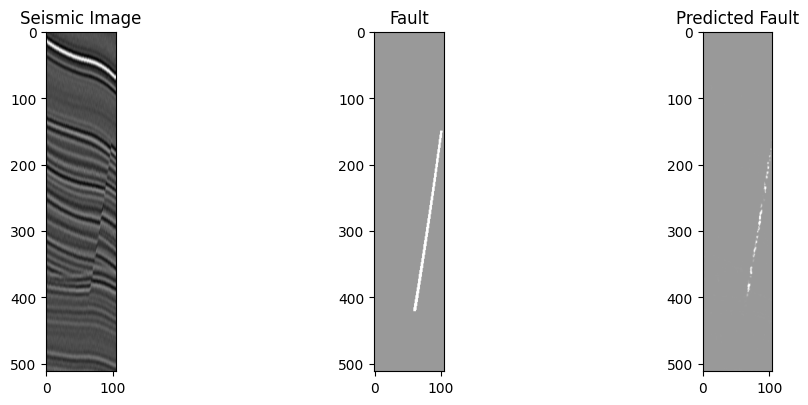

 67%|██████▋   | 200/300 [07:03<03:31,  2.12s/it]

Epoch 3: Step 1100: U-Net loss: 0.01443066168576479


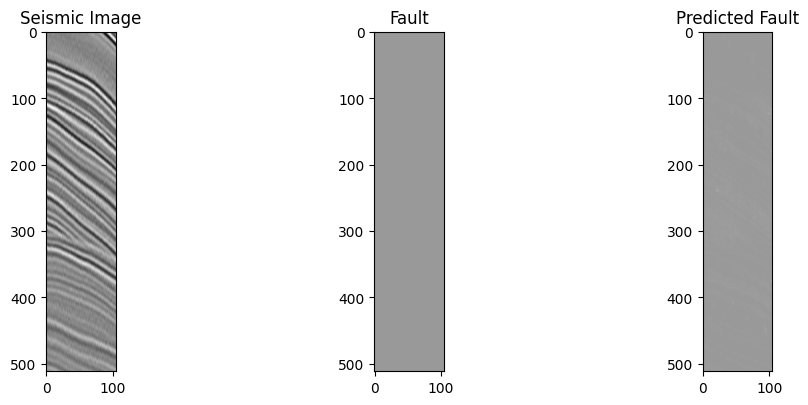

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 4: Step 1200: U-Net loss: 0.003900944720953703


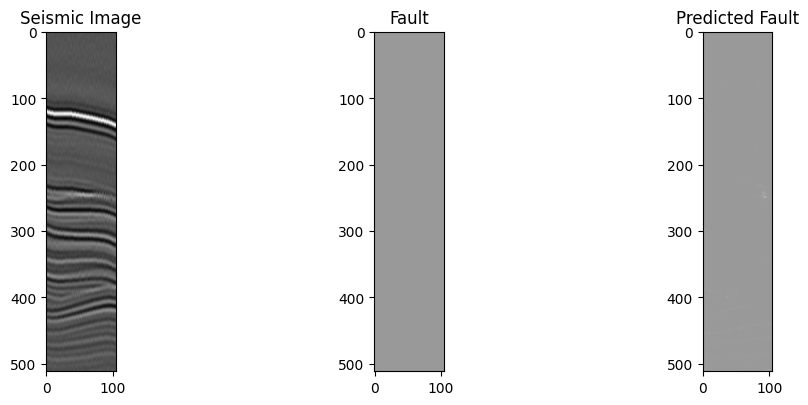

 33%|███▎      | 100/300 [03:32<07:03,  2.12s/it]

Epoch 4: Step 1300: U-Net loss: 0.013721260242164135


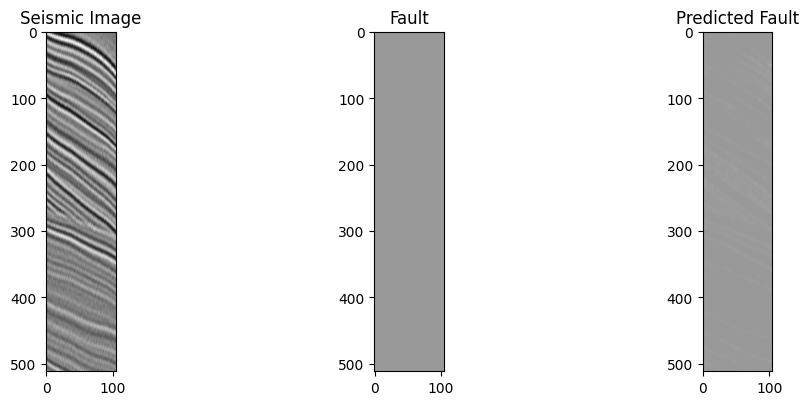

 67%|██████▋   | 200/300 [07:03<03:31,  2.11s/it]

Epoch 4: Step 1400: U-Net loss: 0.09008567035198212


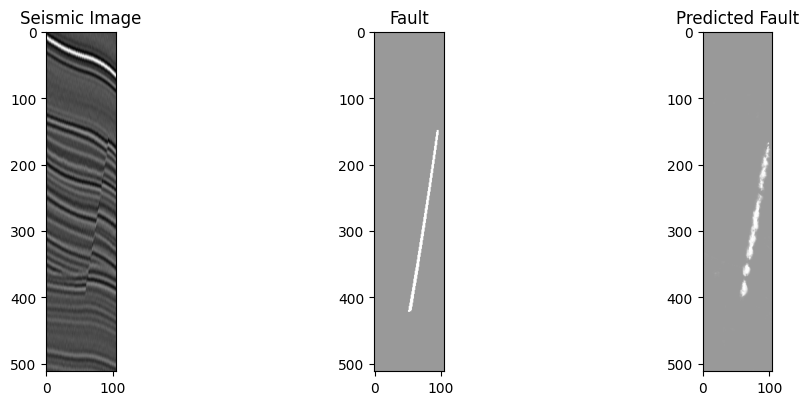

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 5: Step 1500: U-Net loss: 0.002356334589421749


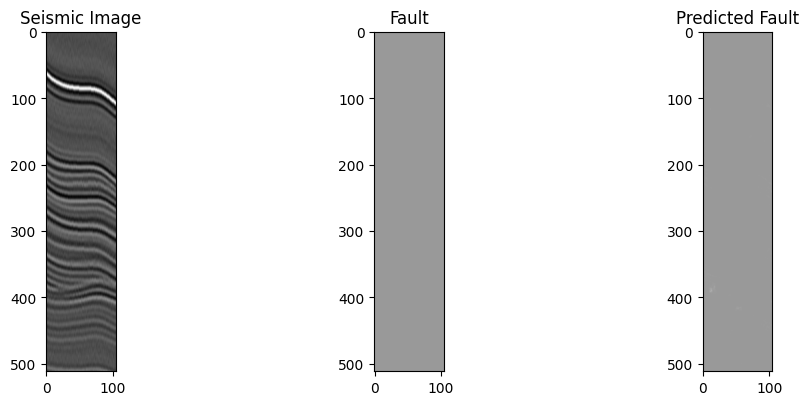

 33%|███▎      | 100/300 [03:31<07:03,  2.12s/it]

Epoch 5: Step 1600: U-Net loss: 0.0005487509770318866


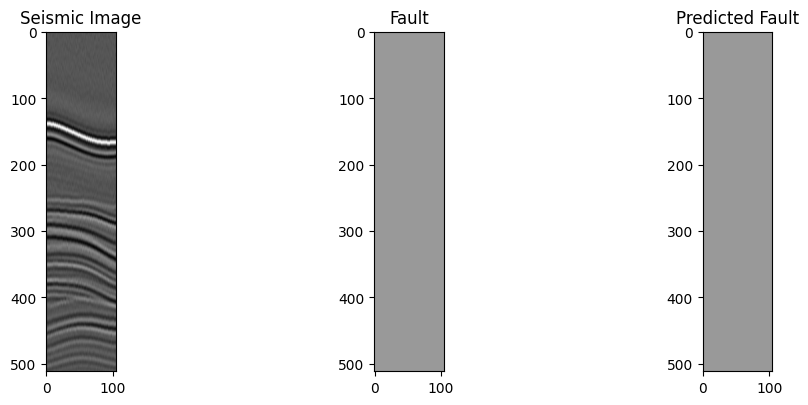

 67%|██████▋   | 200/300 [07:03<03:31,  2.11s/it]

Epoch 5: Step 1700: U-Net loss: 0.036568328738212585


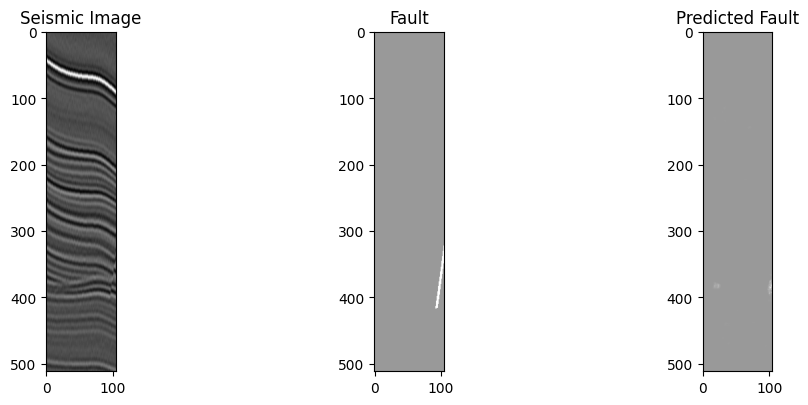

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 6: Step 1800: U-Net loss: 0.0005239399615675211


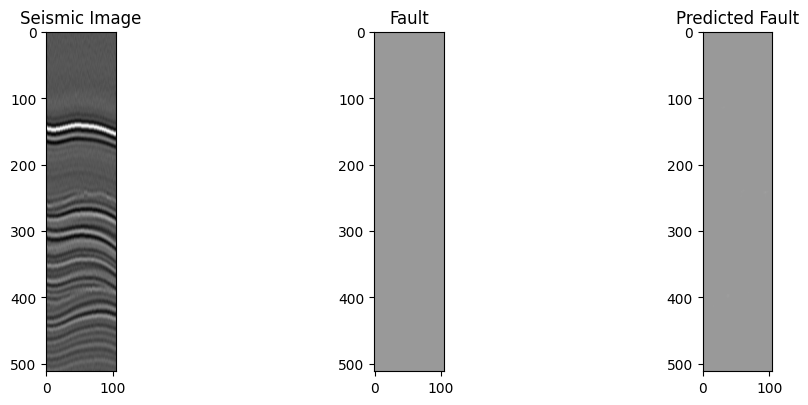

 33%|███▎      | 100/300 [03:31<07:02,  2.11s/it]

Epoch 6: Step 1900: U-Net loss: 0.001180258928798139


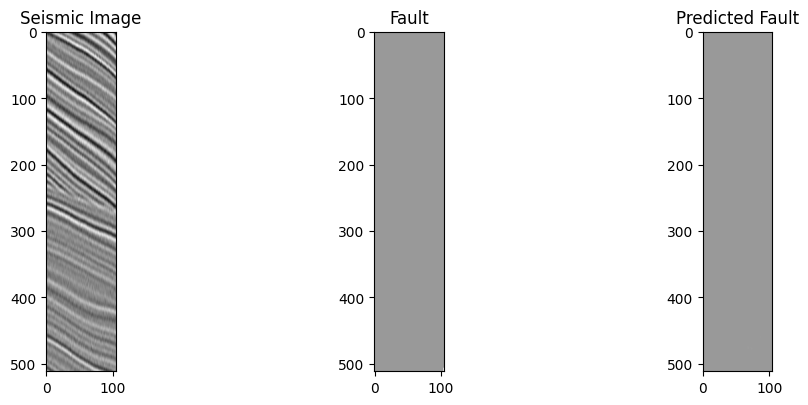

 67%|██████▋   | 200/300 [07:03<03:30,  2.11s/it]

Epoch 6: Step 2000: U-Net loss: 0.002045178785920143


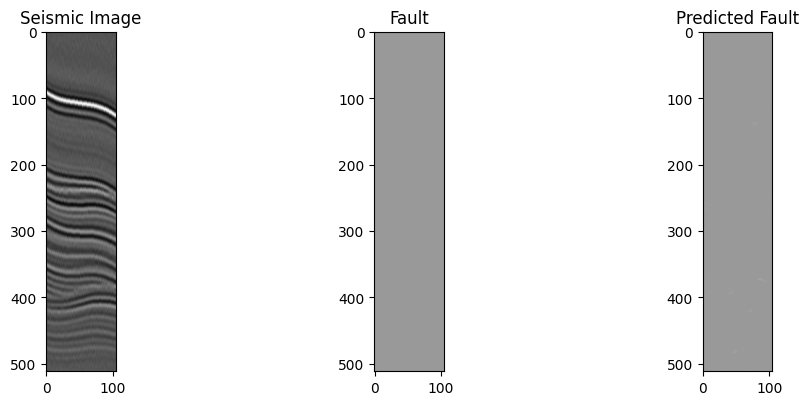

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 7: Step 2100: U-Net loss: 0.16970506310462952


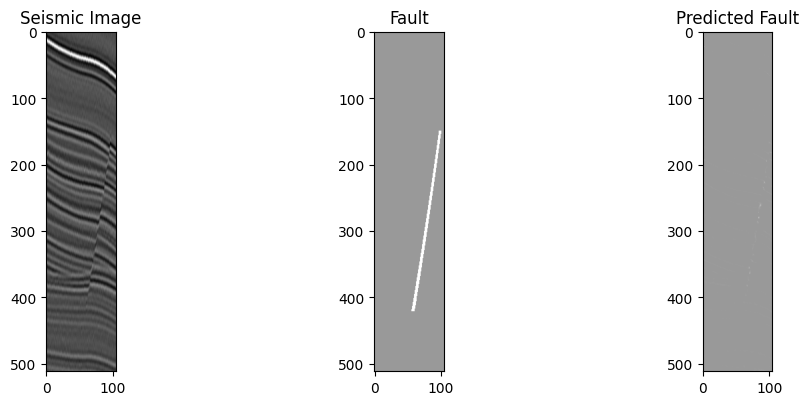

 33%|███▎      | 100/300 [03:31<07:01,  2.11s/it]

Epoch 7: Step 2200: U-Net loss: 0.01429024152457714


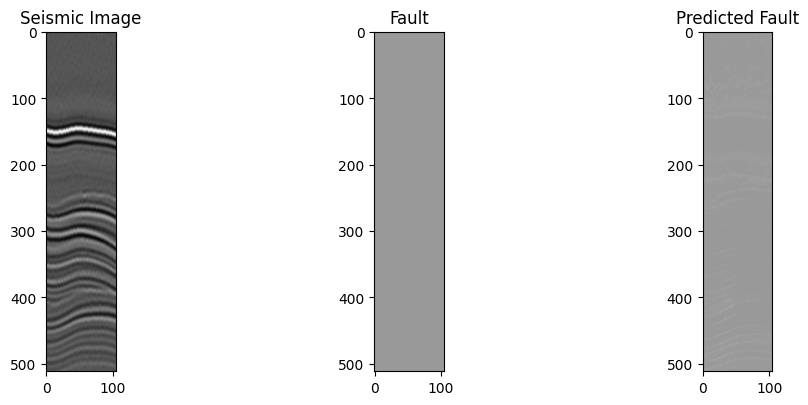

 67%|██████▋   | 200/300 [07:02<03:30,  2.11s/it]

Epoch 7: Step 2300: U-Net loss: 0.0035587528254836798


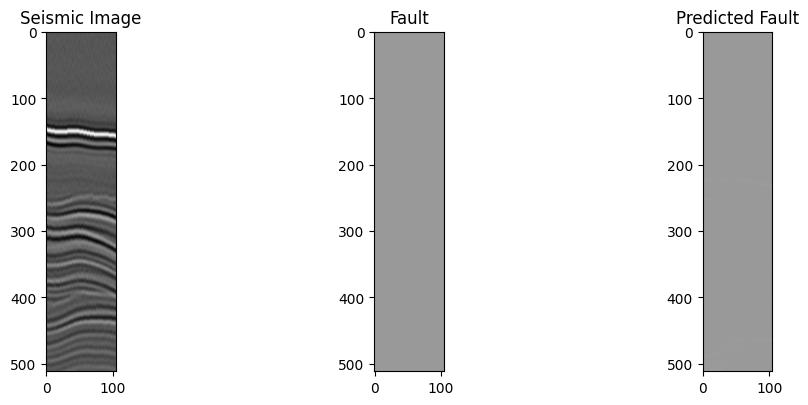

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 8: Step 2400: U-Net loss: 0.0014427924761548638


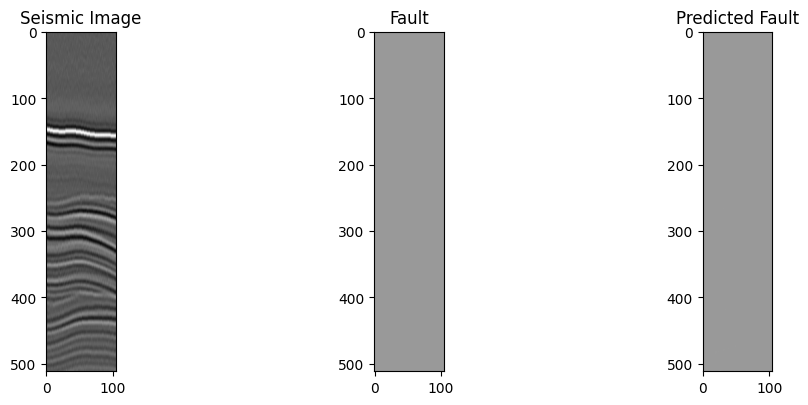

 33%|███▎      | 100/300 [03:31<07:03,  2.12s/it]

Epoch 8: Step 2500: U-Net loss: 0.009588945657014847


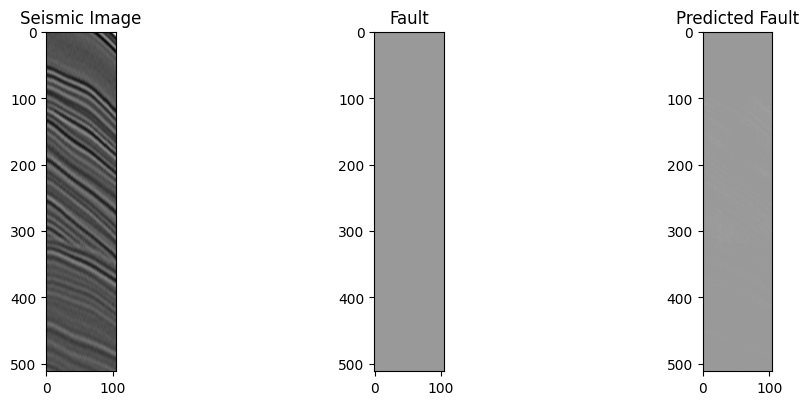

 67%|██████▋   | 200/300 [07:03<03:31,  2.12s/it]

Epoch 8: Step 2600: U-Net loss: 0.007235181983560324


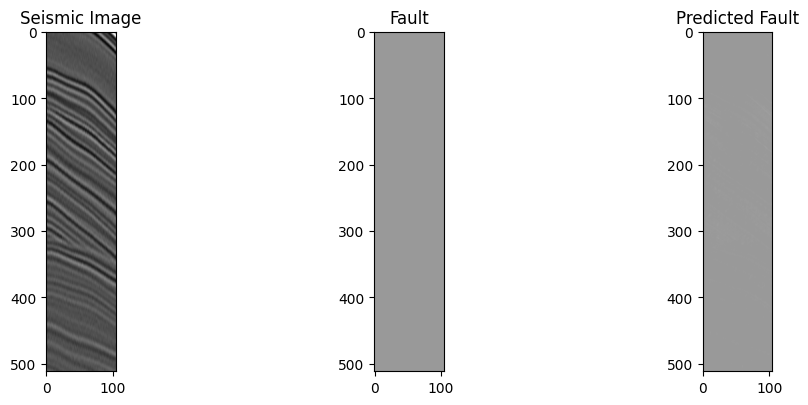

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 9: Step 2700: U-Net loss: 0.10112578421831131


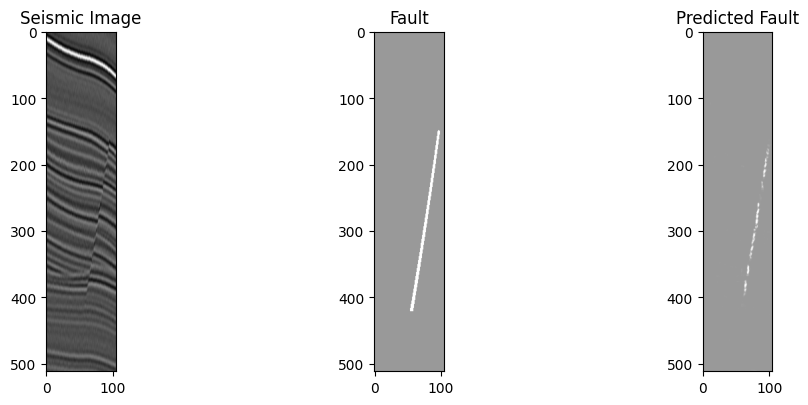

 33%|███▎      | 100/300 [03:32<07:03,  2.12s/it]

Epoch 9: Step 2800: U-Net loss: 0.0026033942122012377


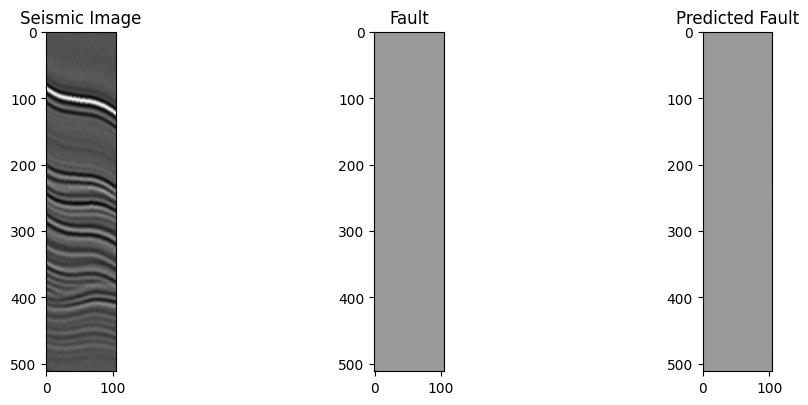

 67%|██████▋   | 200/300 [07:04<03:31,  2.12s/it]

Epoch 9: Step 2900: U-Net loss: 0.006733252666890621


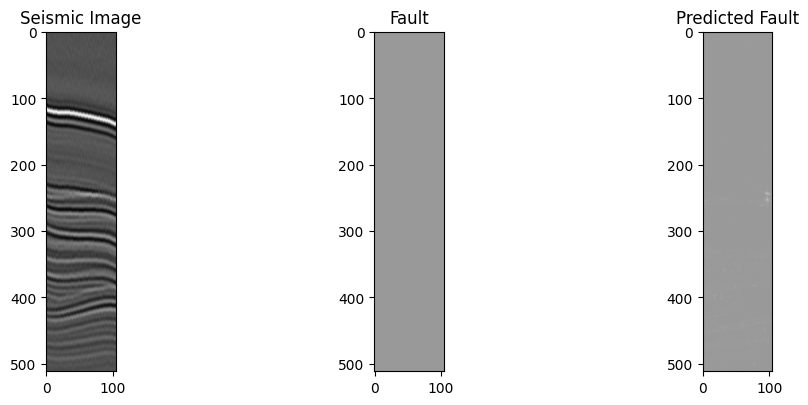

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 10: Step 3000: U-Net loss: 0.0016691491473466158


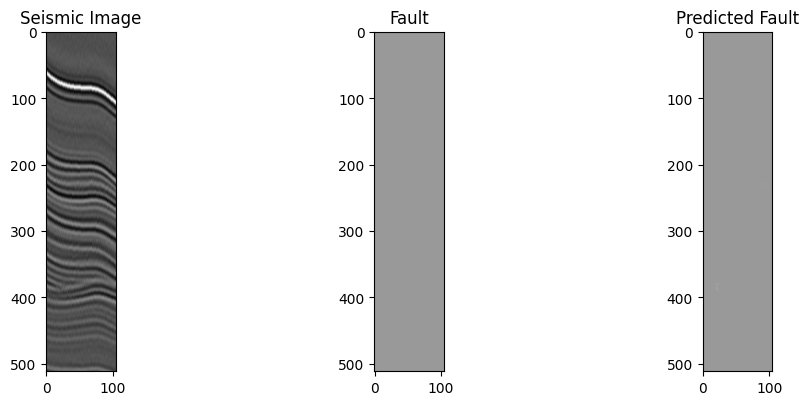

 33%|███▎      | 100/300 [03:32<07:04,  2.12s/it]

Epoch 10: Step 3100: U-Net loss: 0.03497734293341637


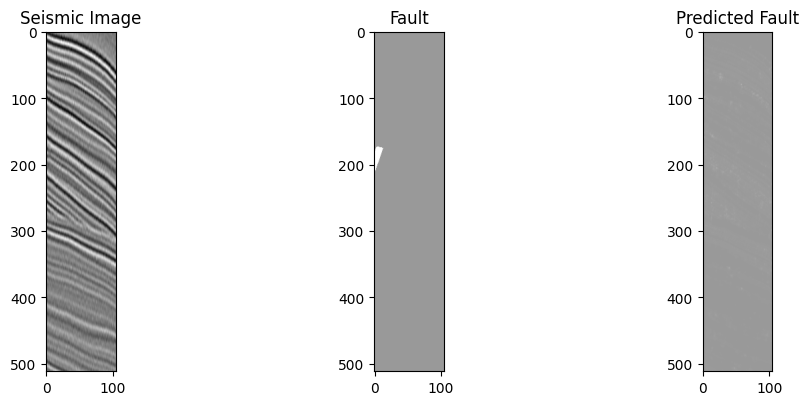

 67%|██████▋   | 200/300 [07:04<03:32,  2.12s/it]

Epoch 10: Step 3200: U-Net loss: 0.0025775672402232885


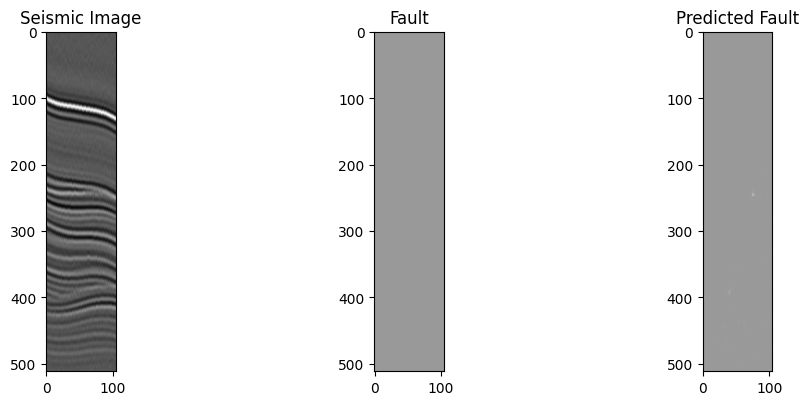

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 11: Step 3300: U-Net loss: 0.002485451987013221


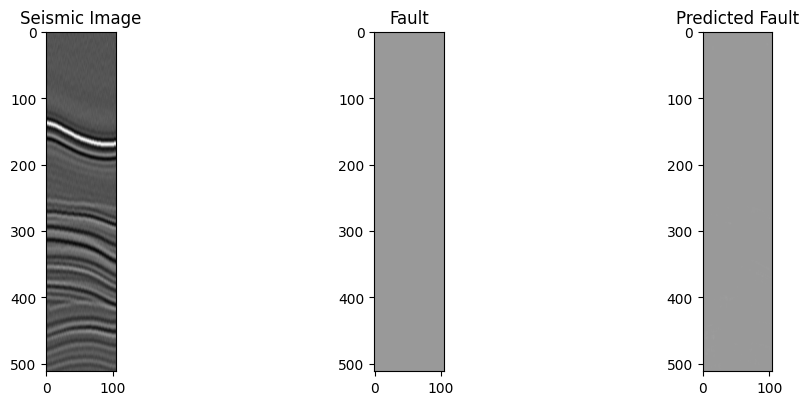

 33%|███▎      | 100/300 [03:32<07:04,  2.12s/it]

Epoch 11: Step 3400: U-Net loss: 0.0024663745425641537


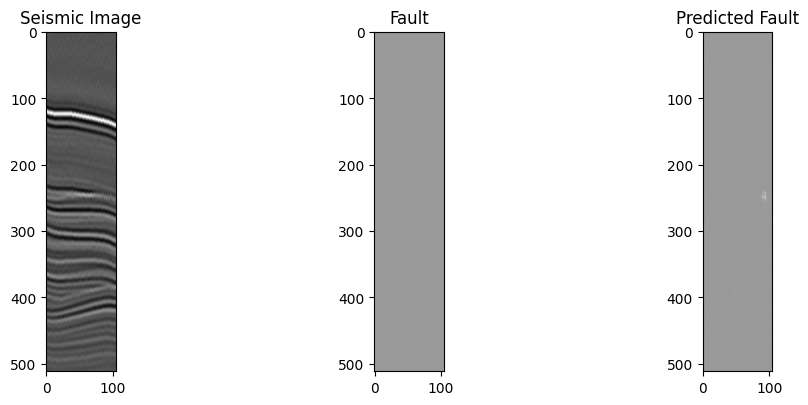

 67%|██████▋   | 200/300 [07:04<03:31,  2.12s/it]

Epoch 11: Step 3500: U-Net loss: 0.0018044001189991832


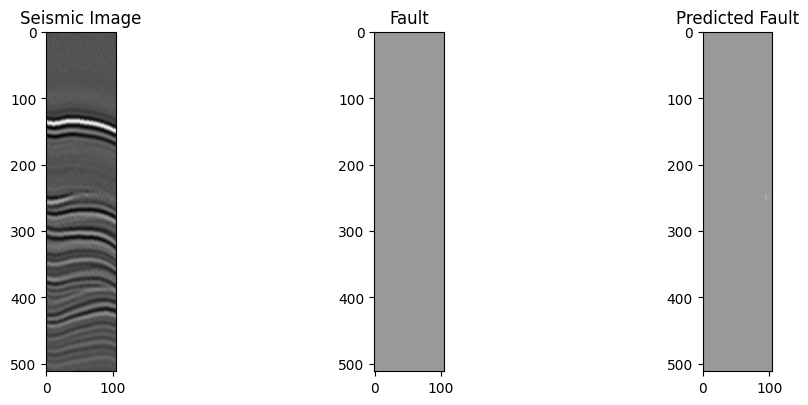

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 12: Step 3600: U-Net loss: 0.0009937919676303864


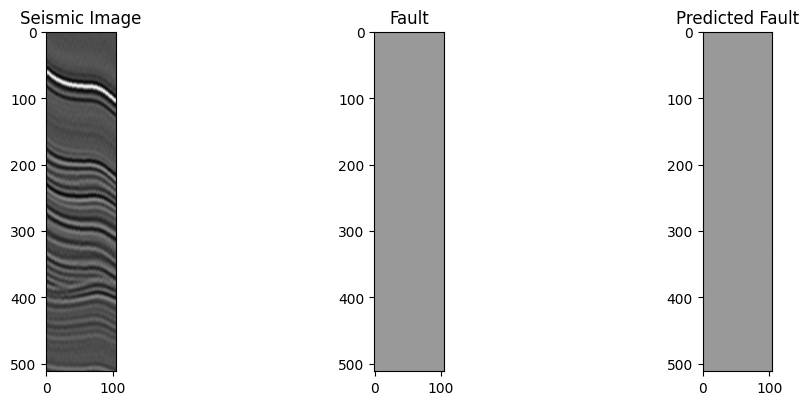

 33%|███▎      | 100/300 [03:31<07:03,  2.12s/it]

Epoch 12: Step 3700: U-Net loss: 0.0015871332725510001


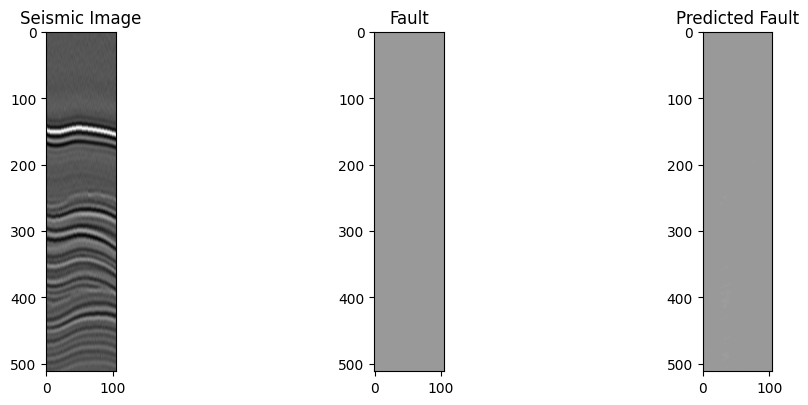

 67%|██████▋   | 200/300 [07:03<03:32,  2.12s/it]

Epoch 12: Step 3800: U-Net loss: 0.002551734447479248


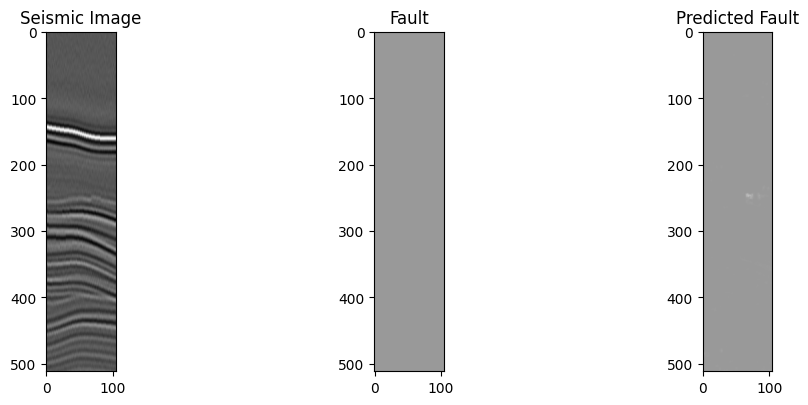

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 13: Step 3900: U-Net loss: 0.008165400475263596


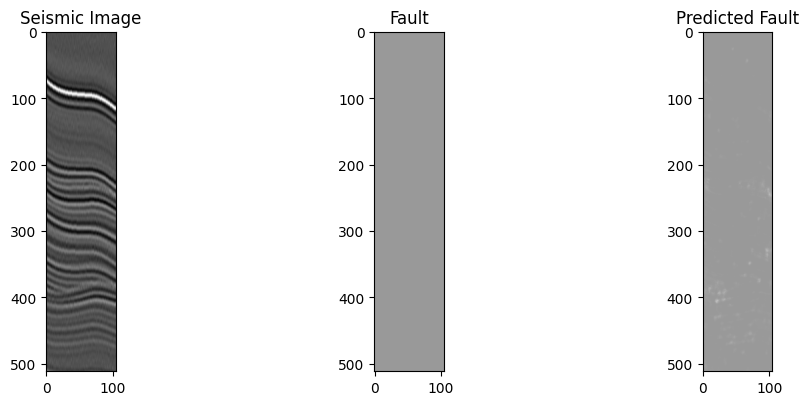

 33%|███▎      | 100/300 [03:31<07:00,  2.10s/it]

Epoch 13: Step 4000: U-Net loss: 0.0059779430739581585


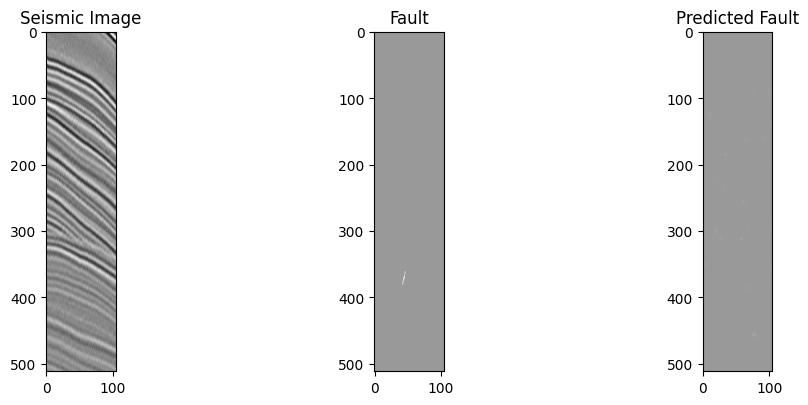

 67%|██████▋   | 200/300 [07:03<03:31,  2.12s/it]

Epoch 13: Step 4100: U-Net loss: 0.0041856905445456505


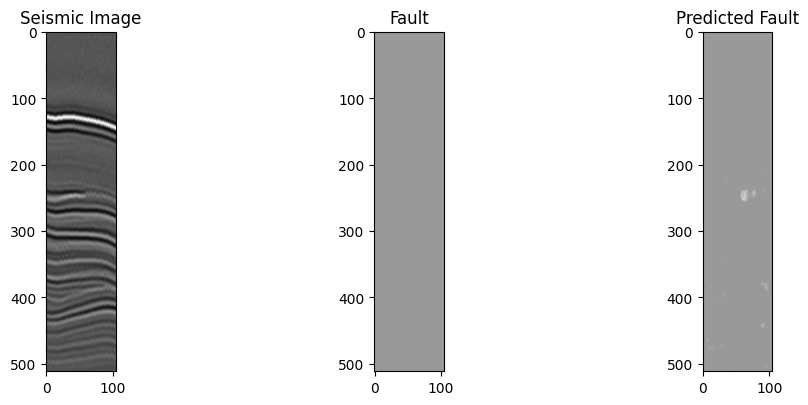

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 14: Step 4200: U-Net loss: 0.0010408834787085652


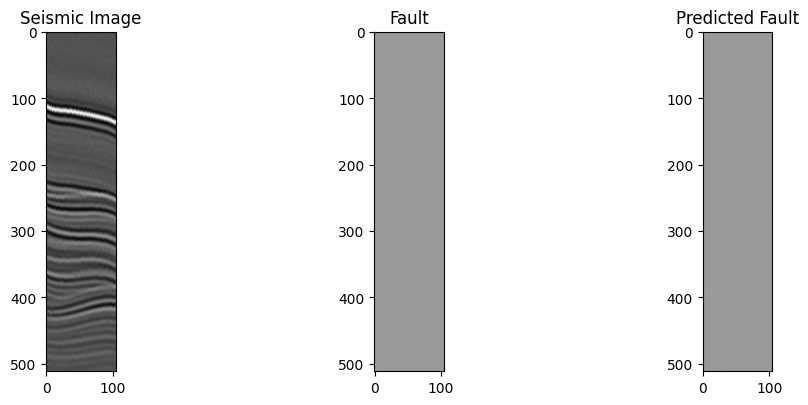

 33%|███▎      | 100/300 [03:31<07:02,  2.11s/it]

Epoch 14: Step 4300: U-Net loss: 0.0019322599982842803


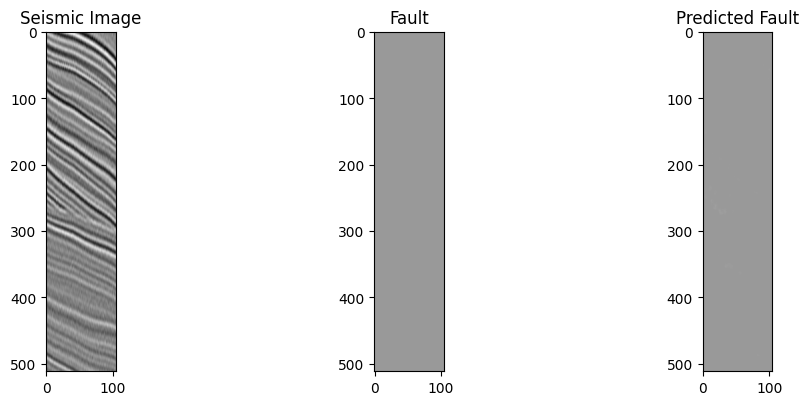

 67%|██████▋   | 200/300 [07:03<03:31,  2.11s/it]

Epoch 14: Step 4400: U-Net loss: 0.004088705871254206


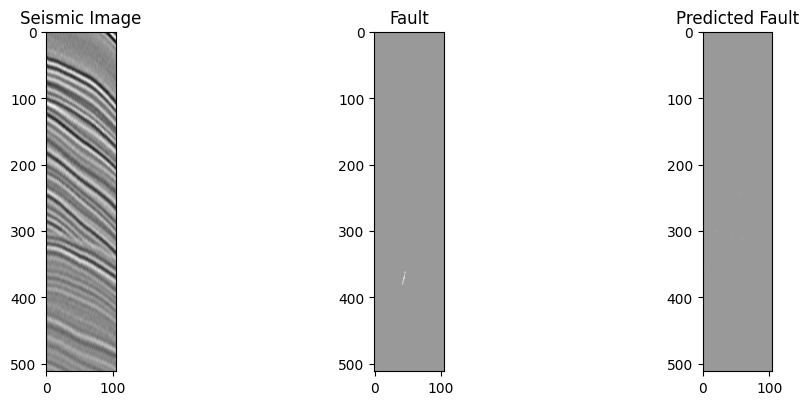

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 15: Step 4500: U-Net loss: 0.0018303107935935259


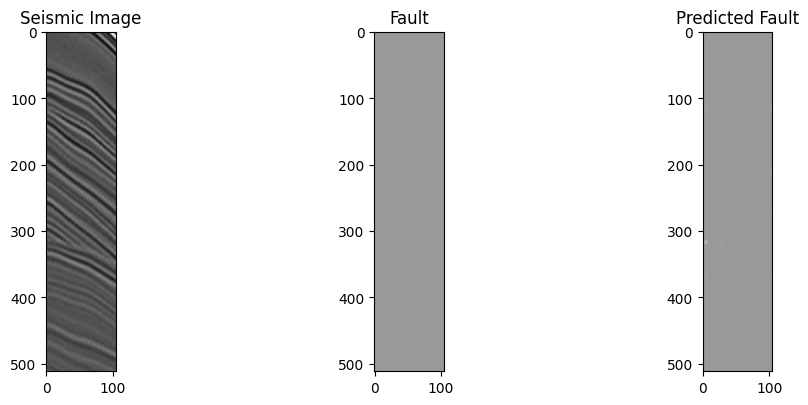

 33%|███▎      | 100/300 [03:31<07:01,  2.11s/it]

Epoch 15: Step 4600: U-Net loss: 0.004168348386883736


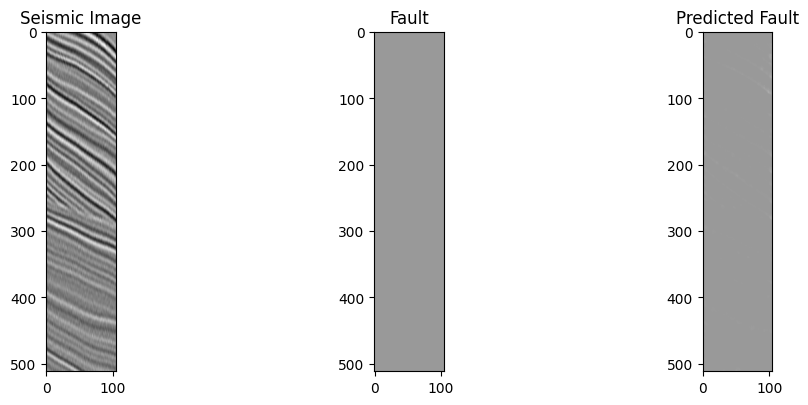

 67%|██████▋   | 200/300 [07:03<03:31,  2.11s/it]

Epoch 15: Step 4700: U-Net loss: 0.002153669949620962


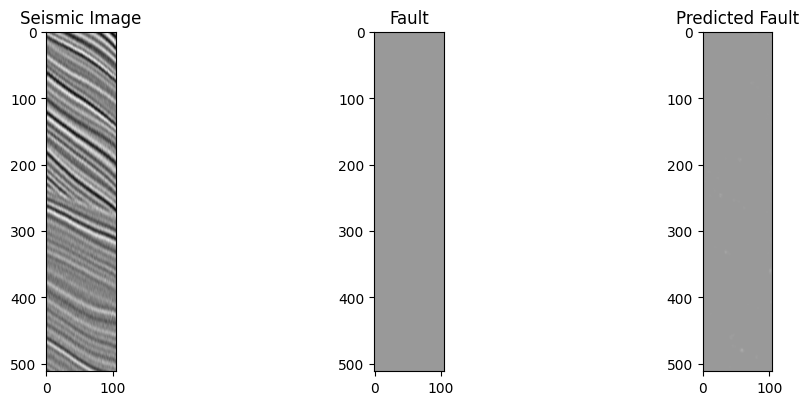

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 16: Step 4800: U-Net loss: 0.00048580768634565175


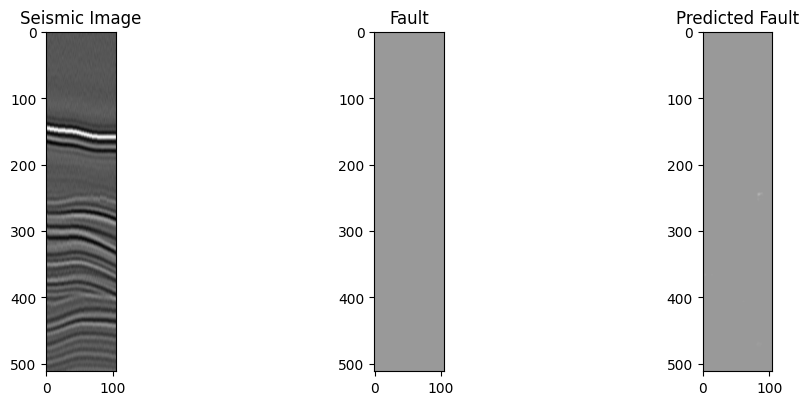

 33%|███▎      | 100/300 [03:31<07:03,  2.12s/it]

Epoch 16: Step 4900: U-Net loss: 0.00221601827070117


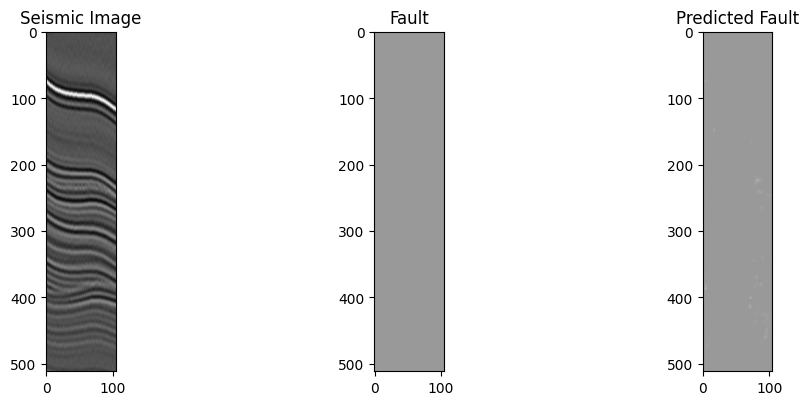

 67%|██████▋   | 200/300 [07:03<03:31,  2.12s/it]

Epoch 16: Step 5000: U-Net loss: 0.0002055660734185949


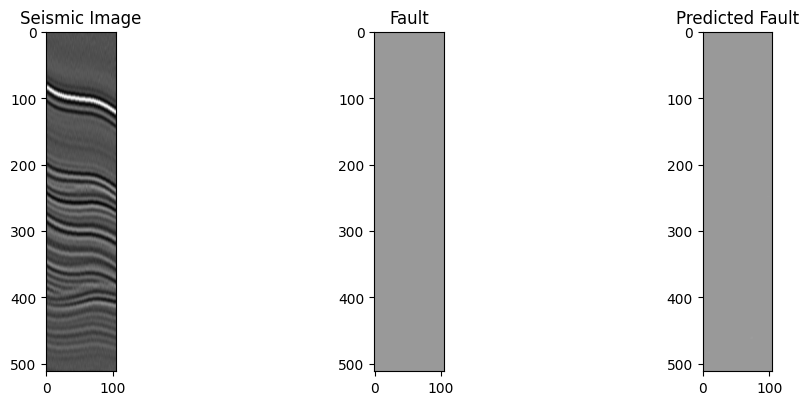

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 17: Step 5100: U-Net loss: 0.0029438689816743135


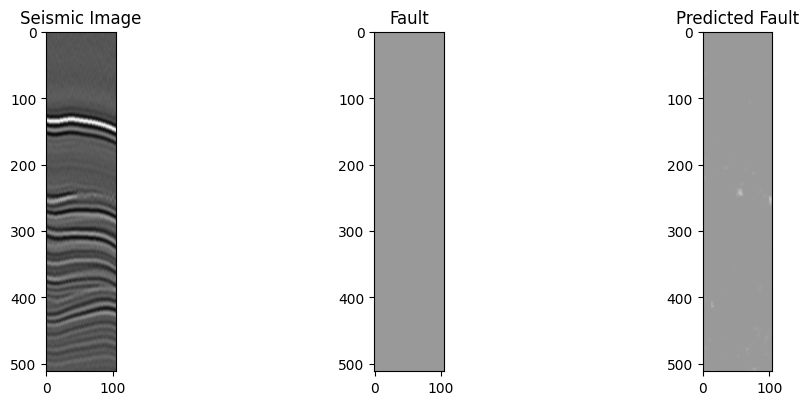

 33%|███▎      | 100/300 [03:32<07:03,  2.12s/it]

Epoch 17: Step 5200: U-Net loss: 0.0004143014084547758


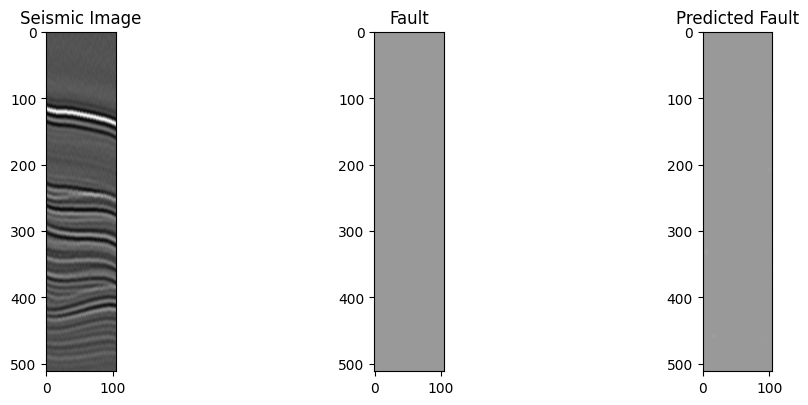

 67%|██████▋   | 200/300 [07:03<03:31,  2.11s/it]

Epoch 17: Step 5300: U-Net loss: 0.07768427580595016


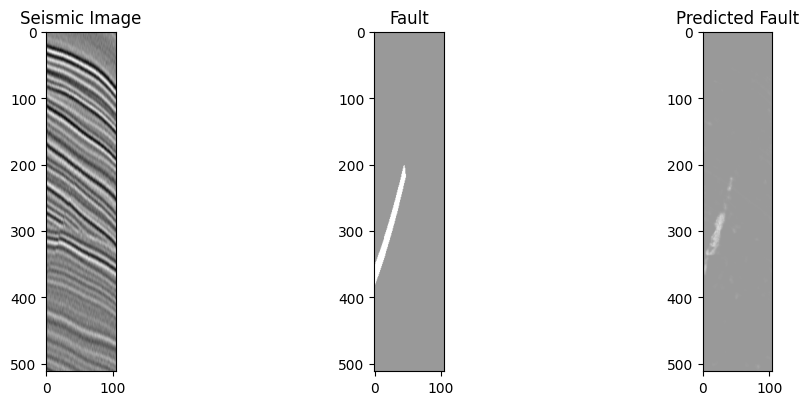

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 18: Step 5400: U-Net loss: 0.05162526294589043


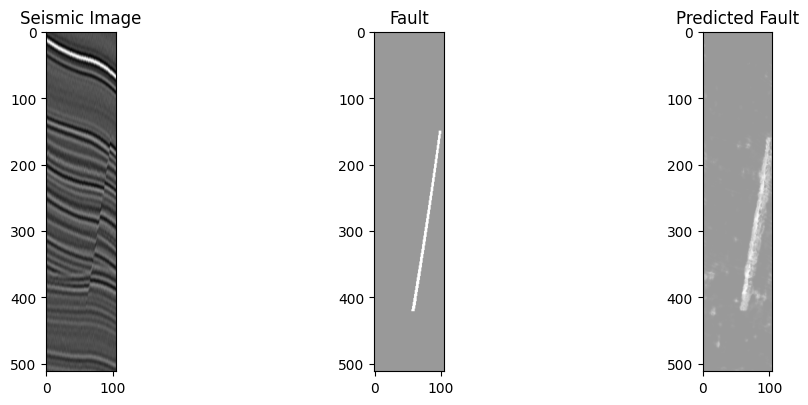

 33%|███▎      | 100/300 [03:31<07:03,  2.12s/it]

Epoch 18: Step 5500: U-Net loss: 0.0024533194955438375


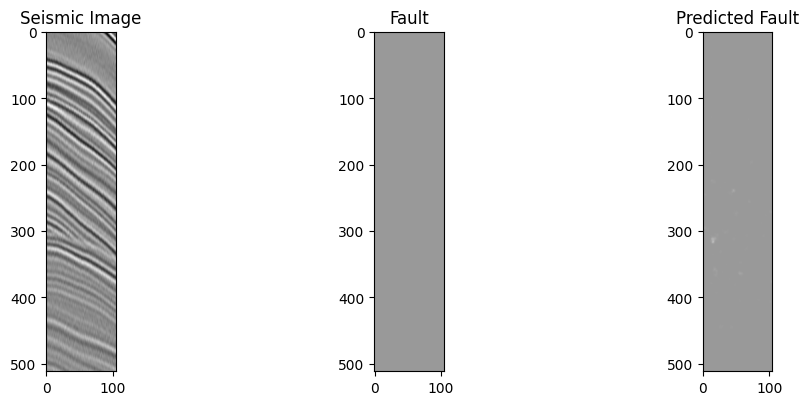

 67%|██████▋   | 200/300 [07:03<03:31,  2.12s/it]

Epoch 18: Step 5600: U-Net loss: 0.001978860702365637


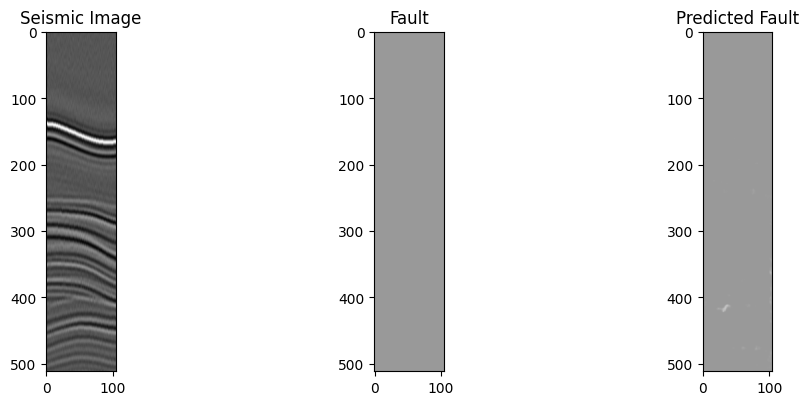

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 19: Step 5700: U-Net loss: 0.000611437251791358


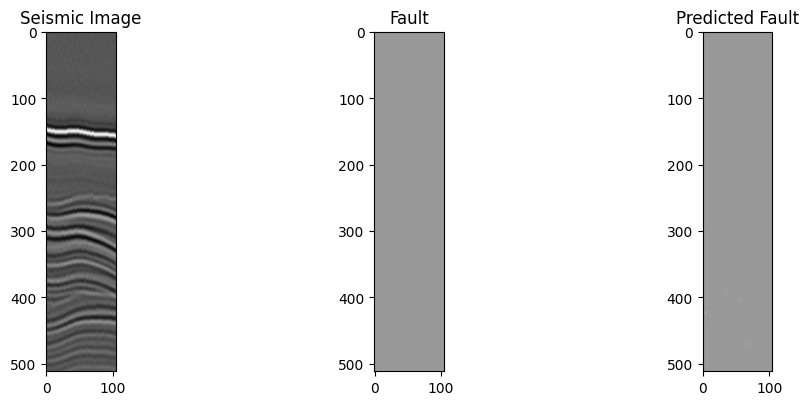

 33%|███▎      | 100/300 [03:31<07:03,  2.12s/it]

Epoch 19: Step 5800: U-Net loss: 0.018819540739059448


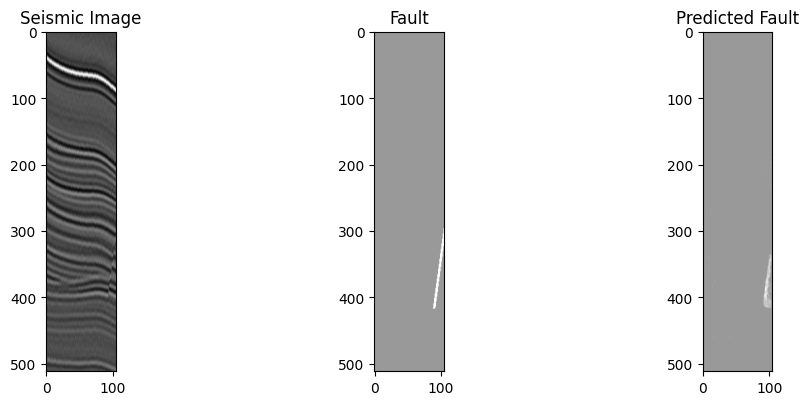

 67%|██████▋   | 200/300 [07:03<03:31,  2.12s/it]

Epoch 19: Step 5900: U-Net loss: 0.000498640991281718


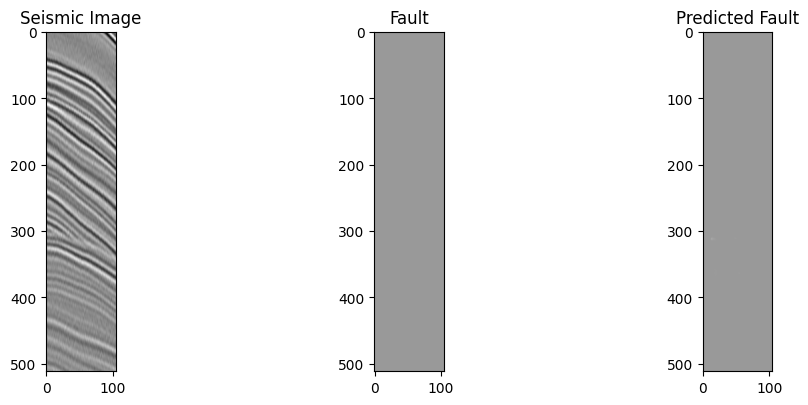

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 20: Step 6000: U-Net loss: 0.0002426932187518105


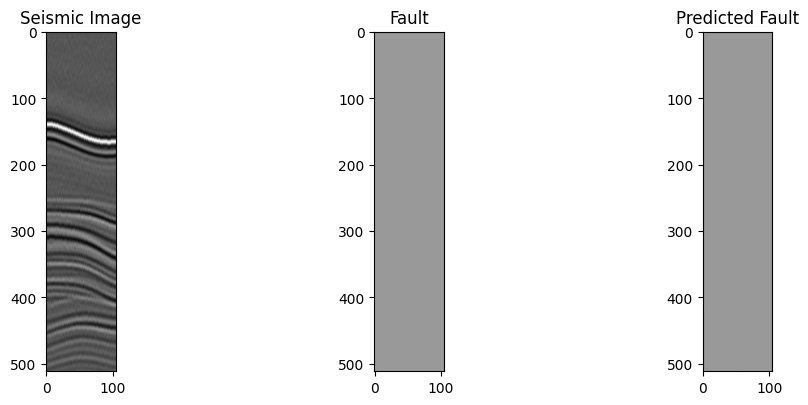

 33%|███▎      | 100/300 [03:31<07:02,  2.11s/it]

Epoch 20: Step 6100: U-Net loss: 0.05730269476771355


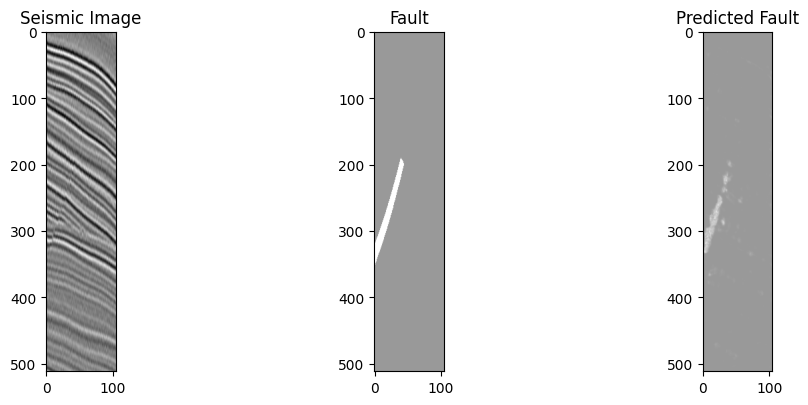

 67%|██████▋   | 200/300 [07:03<03:31,  2.12s/it]

Epoch 20: Step 6200: U-Net loss: 0.001839548465795815


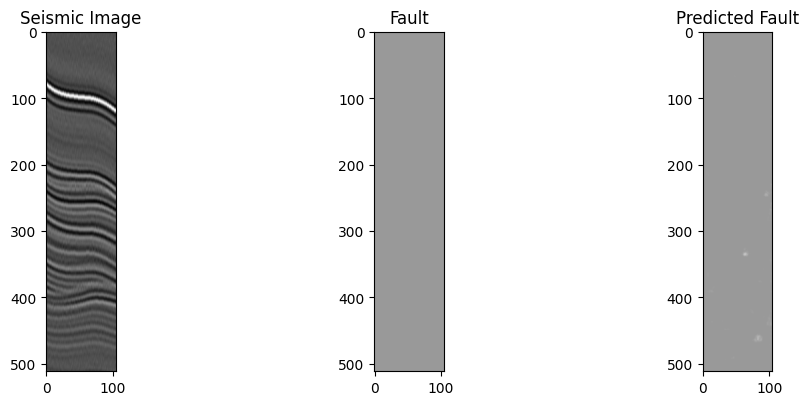

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 21: Step 6300: U-Net loss: 0.03247494995594025


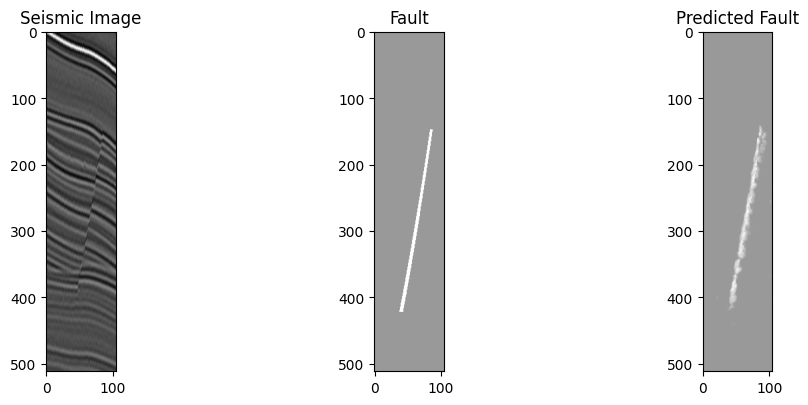

 33%|███▎      | 100/300 [03:31<07:03,  2.12s/it]

Epoch 21: Step 6400: U-Net loss: 0.05833183974027634


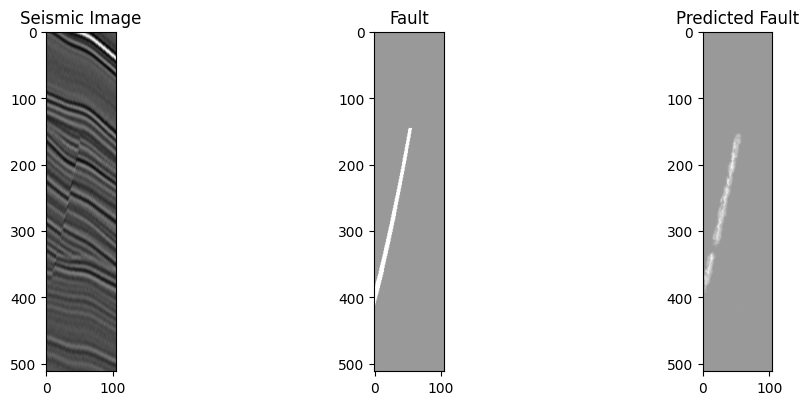

 67%|██████▋   | 200/300 [07:03<03:31,  2.12s/it]

Epoch 21: Step 6500: U-Net loss: 0.0004292532685212791


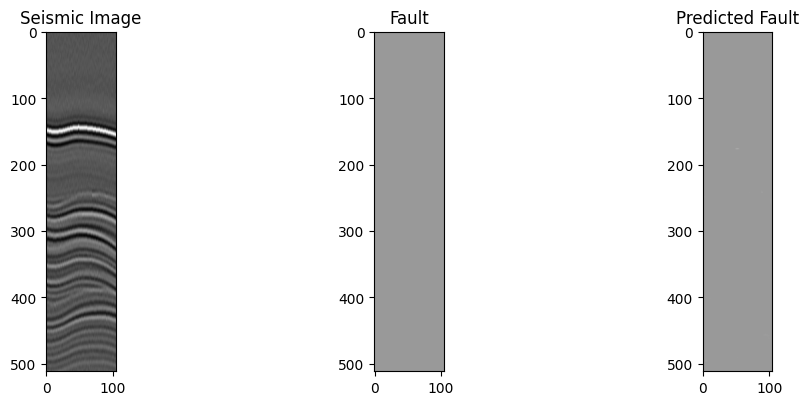

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 22: Step 6600: U-Net loss: 0.006047471426427364


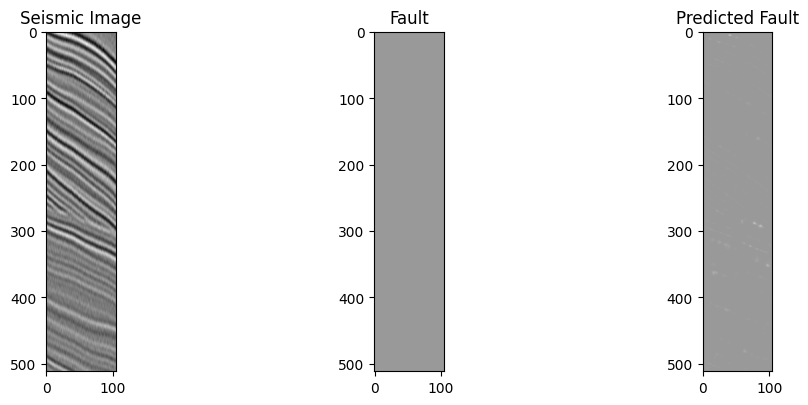

 33%|███▎      | 100/300 [03:31<07:03,  2.12s/it]

Epoch 22: Step 6700: U-Net loss: 0.02766125649213791


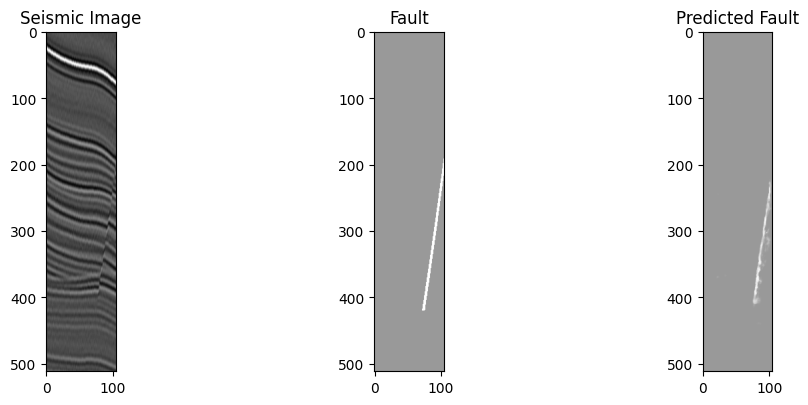

 67%|██████▋   | 200/300 [07:03<03:30,  2.11s/it]

Epoch 22: Step 6800: U-Net loss: 0.0003073961124755442


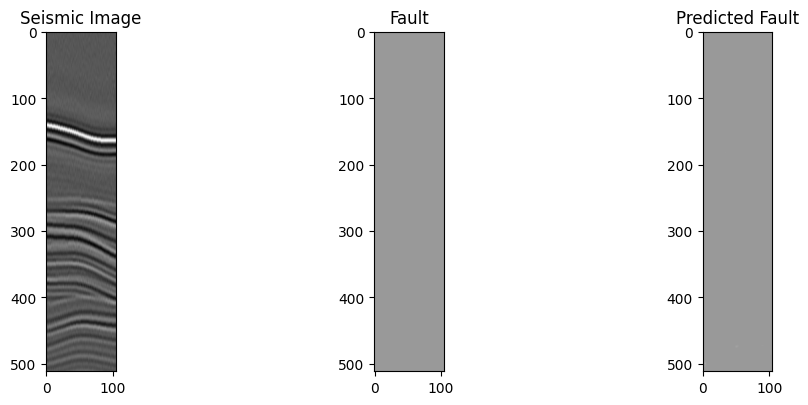

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 23: Step 6900: U-Net loss: 0.0001810646353987977


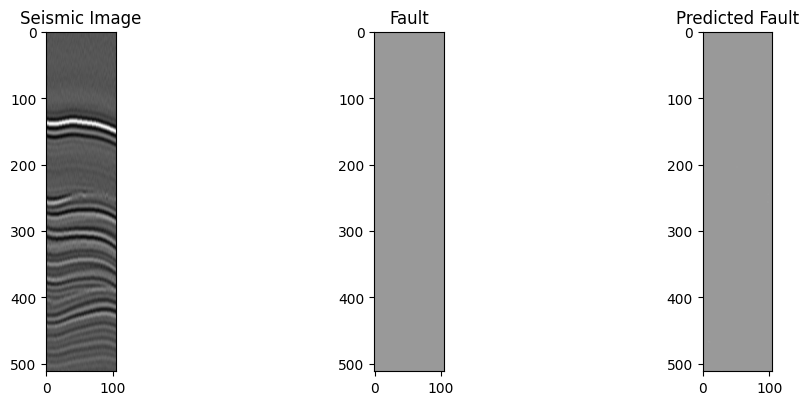

 33%|███▎      | 100/300 [03:31<07:02,  2.11s/it]

Epoch 23: Step 7000: U-Net loss: 0.0002615551638882607


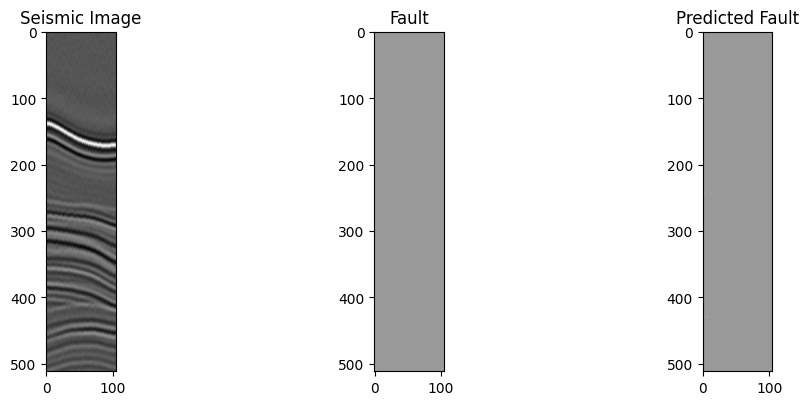

 67%|██████▋   | 200/300 [07:03<03:31,  2.11s/it]

Epoch 23: Step 7100: U-Net loss: 0.0032909843139350414


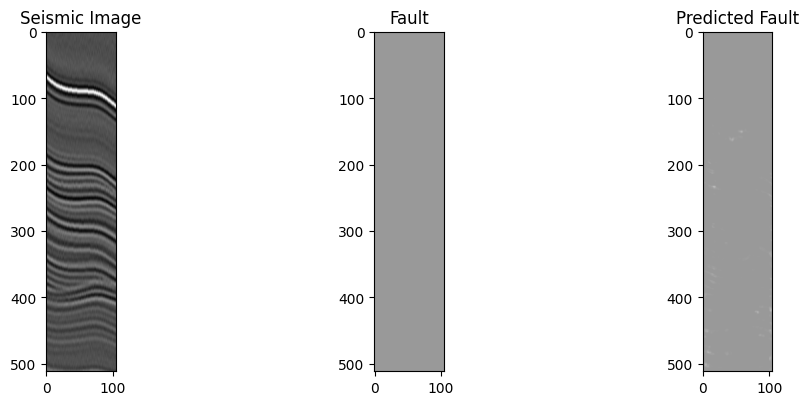

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 24: Step 7200: U-Net loss: 0.0034268260933458805


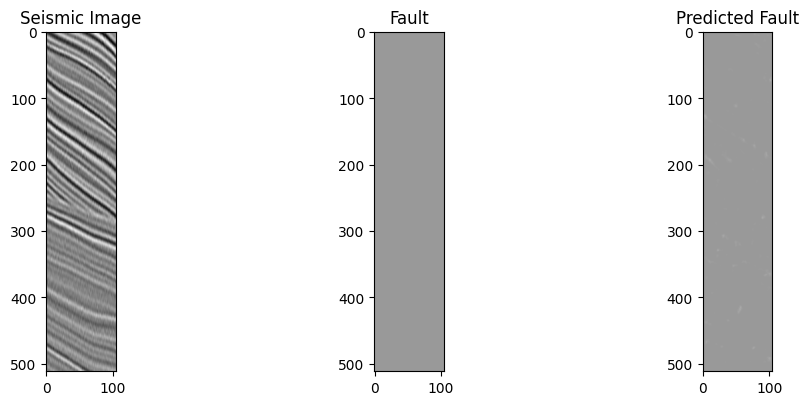

 33%|███▎      | 100/300 [03:31<07:01,  2.11s/it]

Epoch 24: Step 7300: U-Net loss: 0.002999383257701993


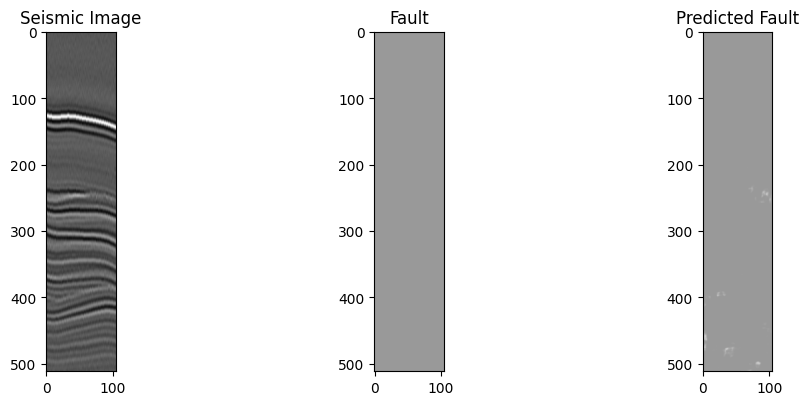

 67%|██████▋   | 200/300 [07:03<03:31,  2.11s/it]

Epoch 24: Step 7400: U-Net loss: 0.0003298599913250655


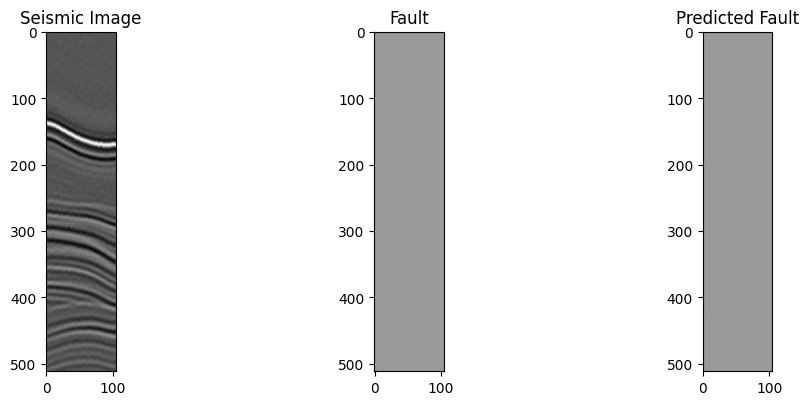

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 25: Step 7500: U-Net loss: 0.0010251632193103433


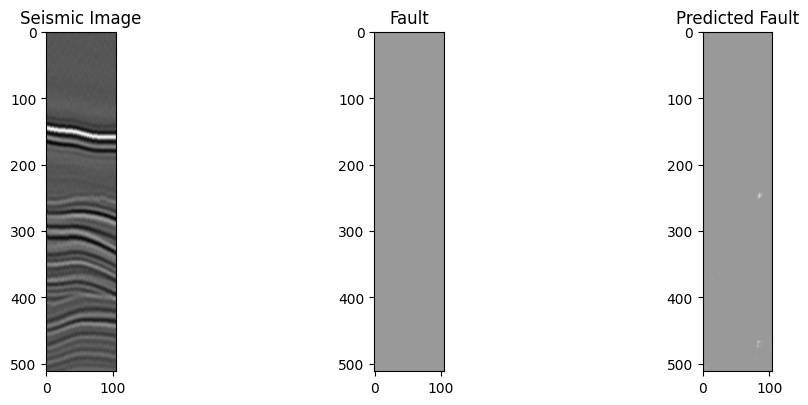

 33%|███▎      | 100/300 [03:31<07:03,  2.12s/it]

Epoch 25: Step 7600: U-Net loss: 0.0006314914207905531


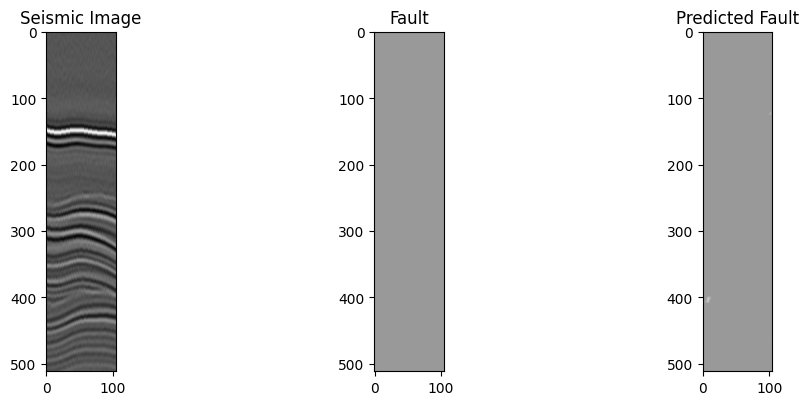

 67%|██████▋   | 200/300 [07:03<03:31,  2.12s/it]

Epoch 25: Step 7700: U-Net loss: 4.869277108809911e-05


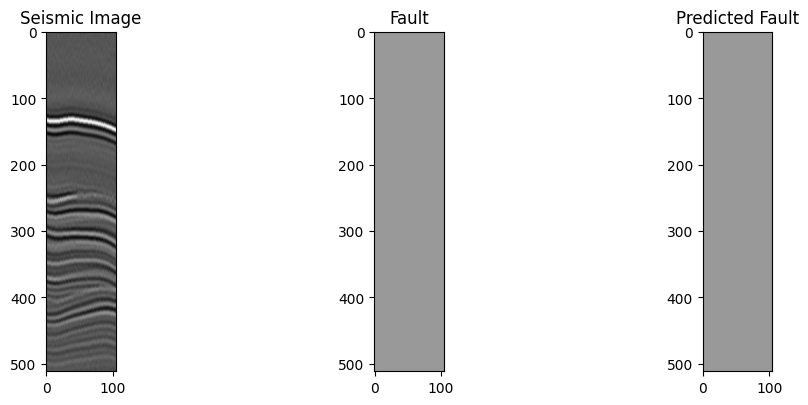

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 26: Step 7800: U-Net loss: 0.0005738307372666895


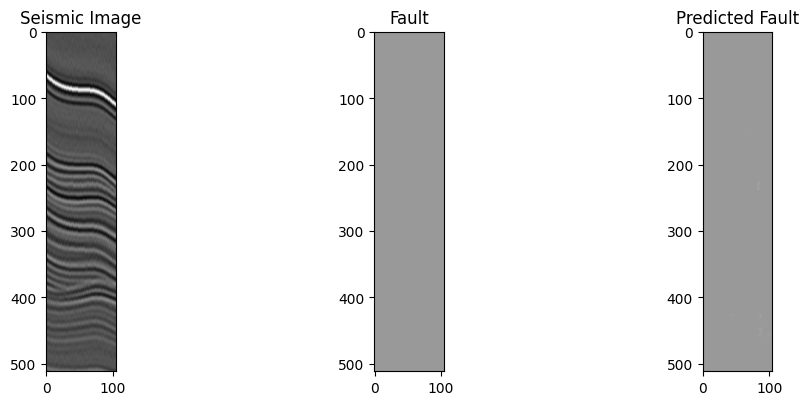

 33%|███▎      | 100/300 [03:31<07:02,  2.11s/it]

Epoch 26: Step 7900: U-Net loss: 0.00017894184566102922


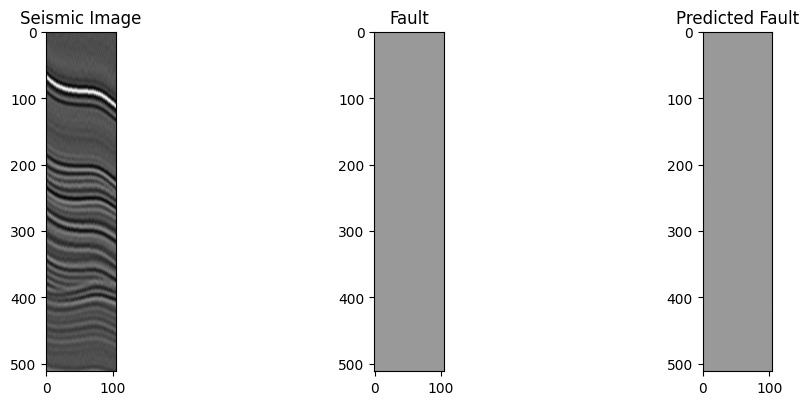

 67%|██████▋   | 200/300 [07:03<03:31,  2.11s/it]

Epoch 26: Step 8000: U-Net loss: 0.002079963218420744


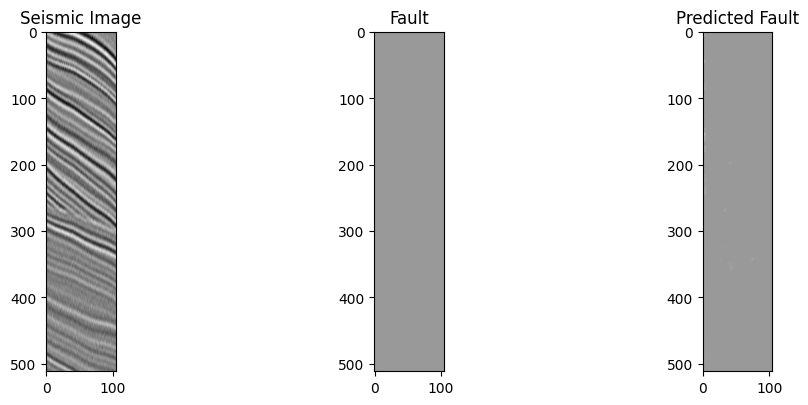

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 27: Step 8100: U-Net loss: 0.033353134989738464


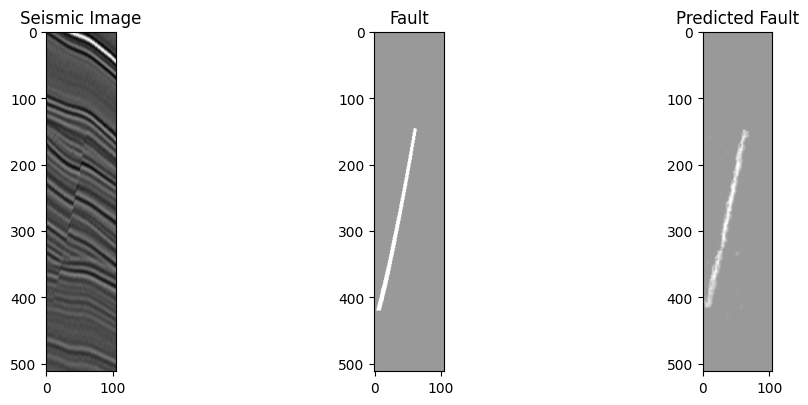

 33%|███▎      | 100/300 [03:31<07:01,  2.11s/it]

Epoch 27: Step 8200: U-Net loss: 0.0014140181010589004


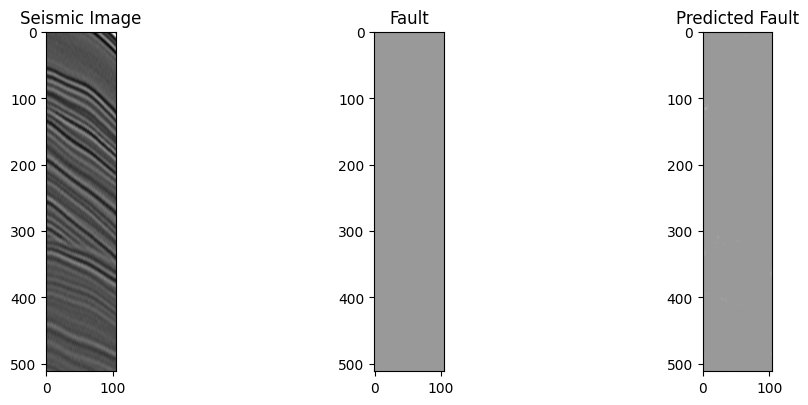

 67%|██████▋   | 200/300 [07:03<03:31,  2.11s/it]

Epoch 27: Step 8300: U-Net loss: 0.0002251091500511393


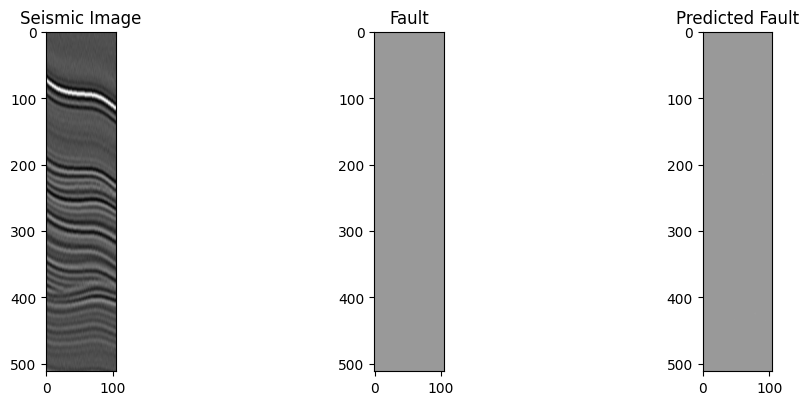

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 28: Step 8400: U-Net loss: 8.401699597015977e-05


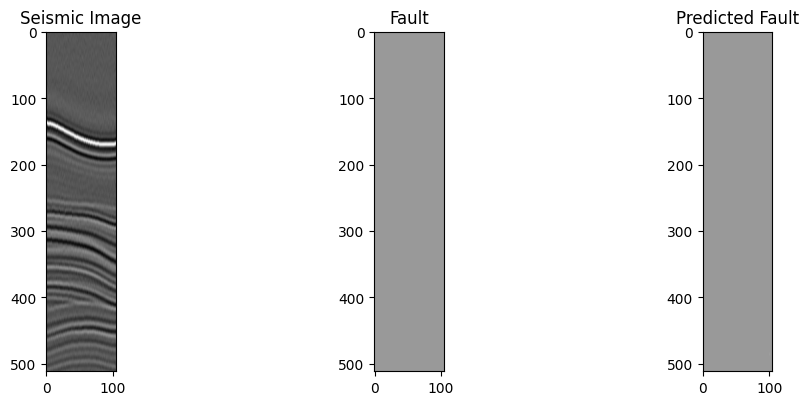

 33%|███▎      | 100/300 [03:31<07:03,  2.12s/it]

Epoch 28: Step 8500: U-Net loss: 0.00017101282719522715


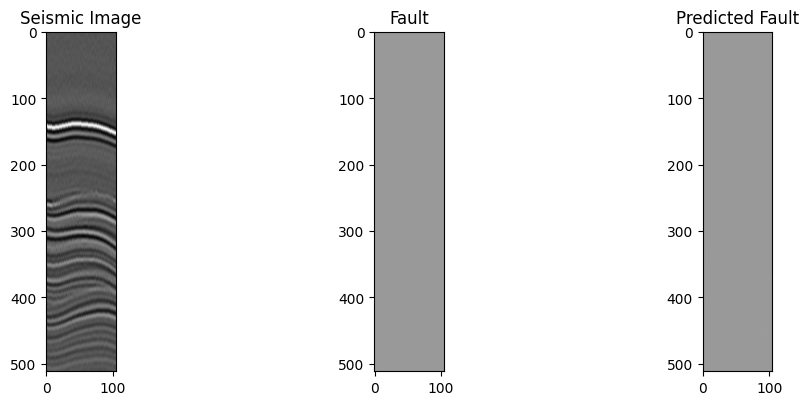

 67%|██████▋   | 200/300 [07:03<03:31,  2.12s/it]

Epoch 28: Step 8600: U-Net loss: 0.02138190157711506


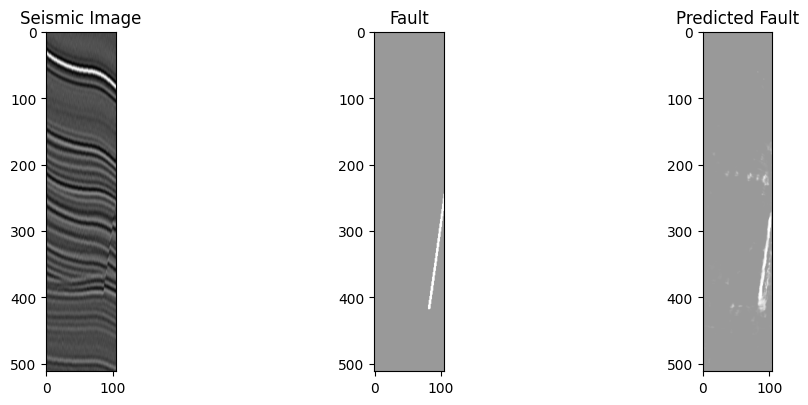

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 29: Step 8700: U-Net loss: 0.028299778699874878


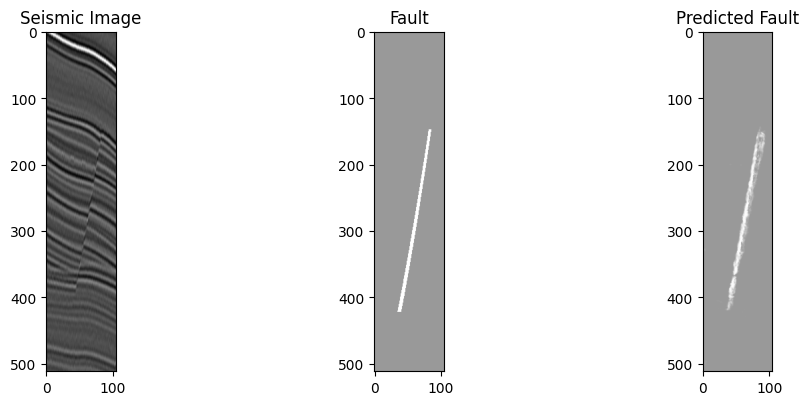

 33%|███▎      | 100/300 [03:31<07:02,  2.11s/it]

Epoch 29: Step 8800: U-Net loss: 0.0009994826978072524


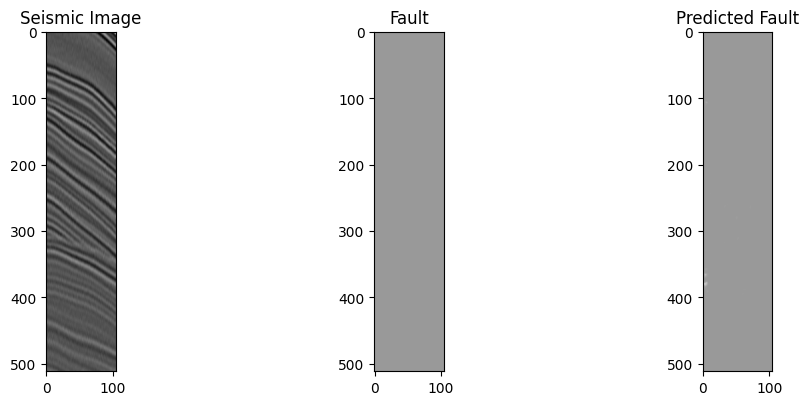

 67%|██████▋   | 200/300 [07:03<03:31,  2.12s/it]

Epoch 29: Step 8900: U-Net loss: 0.0002141769218724221


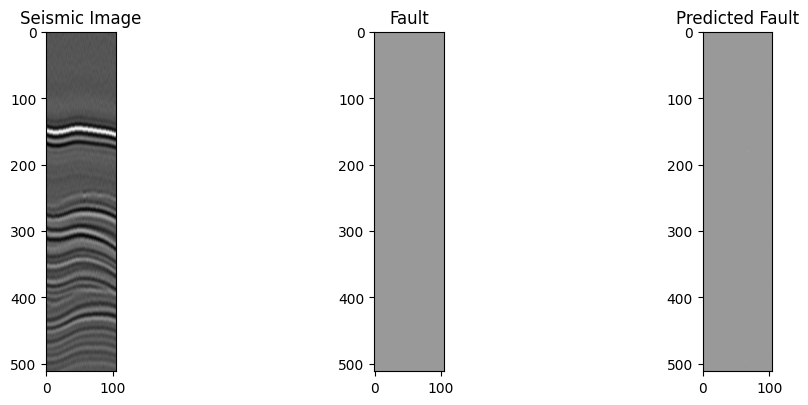

100%|██████████| 300/300 [10:35<00:00,  2.12s/it]


In [269]:
model, pred, loss = train()

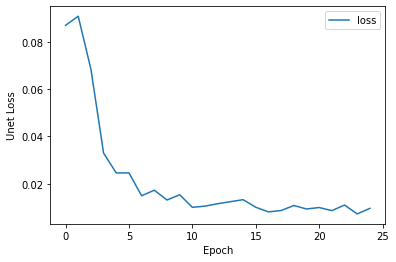

In [ ]:
plt.plot(loss, label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Unet Loss')
plt.legend()
plt.show()